# __Springboard Data Science Capstone 3 Project__
# _Predicting the Price of Energy_

### Pre-Processing & Modeling

##### _Ben Takacs_
###### __Python version 3.10.4__

### __Imports and File Location__

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,  mean_squared_error, root_mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Plot settings
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

## __Pre-Processing__

### __Load Data__

In [3]:
df = pd.read_csv('./data/df1.csv', index_col=0)
df.index = pd.to_datetime(df.index)
df

Average Price of Electricity to Ultimate Customers, Commercial  \
Month                                                                        
1990-02-01                                               7.15                
1990-03-01                                               7.23                
1990-04-01                                               7.20                
1990-05-01                                               7.31                
1990-06-01                                               7.49                
...                                                       ...                
2024-05-01                                              12.48                
2024-06-01                                              13.07                
2024-07-01                                              13.58                
2024-08-01                                              13.39                
2024-09-01                                              13.47                

            Total Renewable Energy Consumption  \
Month                                            
1990-02-01                            0.321465   
1990-03-01                            0.353956   
1990-04-01                            0.334136   
1990-05-01                            0.317791   
1990-06-01                            0.289276   
...                                        ...   
2024-05-01                            0.758321   
2024-06-01                            0.742351   
2024-07-01                            0.733689   
2024-08-01                            0.732437   
2024-09-01                            0.679444   

            Total Petroleum Consumed by the Commercial Sector  \
Month                                                           
1990-02-01                                             89.232   
1990-03-01                                             85.491   
1990-04-01                                             76.051   
1990-05-01                                             73.229   
1990-06-01                                             73.648   
...                                                       ...   
2024-05-01                                             71.672   
2024-06-01                                             63.796   
2024-07-01                                             60.285   
2024-08-01                                             58.652   
2024-09-01                                             63.629   

            Natural Gas Consumed by the Electric Power Sector  \
Month                                                           
1990-02-01                                            153.181   
1990-03-01                                            214.167   
1990-04-01                                            231.641   
1990-05-01                                            283.776   
1990-06-01                                            345.768   
...                                                       ...   
2024-05-01                                           1045.631   
2024-06-01                                           1243.853   
2024-07-01                                           1534.444   
2024-08-01                                           1493.632   
2024-09-01                                           1227.941   

            Natural Gas Consumed by the Transportation Sector, Vehicle Fuel  
Month                                                                        
1990-02-01                                              0.021                
1990-03-01                                              0.023                
1990-04-01                                              0.022                
1990-05-01                                              0.023                
1990-06-01                                              0.022                
...                                                       ...                
2024-05-01                    

Average price is in units of cents per kilowatt hour, including taxes.\
Renewable energy consumption is in units of quadrillion Btu (10^15)\
Petroleum consumption is in units of trillion Btu (10^12)\
Natural gas consumed is in units of billion cubic feet (10^12)\
Need to convert  energies to same unit.
Also going to rename columsn to something easier.

In [4]:
df.rename(columns={'Average Price of Electricity to Ultimate Customers, Commercial':'Price', 'Total Renewable Energy Consumption':'Renewable', 'Total Petroleum Consumed by the Commercial Sector':'Petroleum', 'Natural Gas Consumed by the Electric Power Sector':'Electric', 'Natural Gas Consumed by the Transportation Sector, Vehicle Fuel':'Transportation'}, inplace=True)
# df.Renewable *= 1e3
df

Price  Renewable  Petroleum  Electric  Transportation
Month                                                            
1990-02-01   7.15   0.321465     89.232   153.181           0.021
1990-03-01   7.23   0.353956     85.491   214.167           0.023
1990-04-01   7.20   0.334136     76.051   231.641           0.022
1990-05-01   7.31   0.317791     73.229   283.776           0.023
1990-06-01   7.49   0.289276     73.648   345.768           0.022
...           ...        ...        ...       ...             ...
2024-05-01  12.48   0.758321     71.672  1045.631           4.514
2024-06-01  13.07   0.742351     63.796  1243.853           4.368
2024-07-01  13.58   0.733689     60.285  1534.444           4.514
2024-08-01  13.39   0.732437     58.652  1493.632           4.514
2024-09-01  13.47   0.679444     63.629  1227.941           4.368

[416 rows x 5 columns]

Renewable and Petroleum now have same units (trillion Btu)

In [5]:
exog = pd.read_csv('./data/exog.csv', index_col=0)
exog.set_index(pd.to_datetime(exog.index), inplace=True)
exog

Population           GDP
Month                               
1990-02-01  252.273689  10058.925806
1990-03-01  252.500884  10087.247931
1990-04-01  252.728323  10115.630336
1990-05-01  252.956003  10144.072517
1990-06-01  253.183924  10172.573960
...                ...           ...
2024-05-01  335.258213  23340.273105
2024-06-01  335.309775  23404.211001
2024-07-01  335.359756  23468.810867
2024-08-01  335.408149  23534.080926
2024-09-01  335.454946  23600.029465

[416 rows x 2 columns]

##### Don't need to scale data because it's a time series

### __Test Train Split__

In [6]:
# Make differenced dataframe as well for use with modeling
df_diff = pd.DataFrame()
for col in df.columns:
    df_diff[col] = np.diff(df[col])

df_diff.index = df.index[:-1]
df_diff.dropna(inplace=True)
df_diff

Price  Renewable  Petroleum  Electric  Transportation
Month                                                            
1990-02-01   0.08   0.032491     -3.741    60.986           0.002
1990-03-01  -0.03  -0.019820     -9.440    17.474          -0.001
1990-04-01   0.11  -0.016345     -2.822    52.135           0.001
1990-05-01   0.18  -0.028515      0.419    61.992          -0.001
1990-06-01   0.03   0.026596     -1.102    33.816           0.001
...           ...        ...        ...       ...             ...
2024-04-01  -0.15   0.021792     -2.954   163.693           0.146
2024-05-01   0.59  -0.015970     -7.876   198.222          -0.146
2024-06-01   0.51  -0.008662     -3.511   290.591           0.146
2024-07-01  -0.19  -0.001252     -1.633   -40.812           0.000
2024-08-01   0.08  -0.052993      4.977  -265.691          -0.146

[415 rows x 5 columns]

In [7]:
split = 0.8
splitdate = datetime.date(df.index[int(len(df)*split)].year, df.index[int(len(df)*split)].month,1)
splitdateahead = datetime.date(splitdate.year, splitdate.month+1,1)
splitdateback = datetime.date(splitdate.year, splitdate.month-1,1)

print(splitdate)
#Endogenous vars
# normal
train, test = train_test_split(df, train_size=split, shuffle=False)
ytrain = train.Price; ytest = test.Price
xtrain = train.drop(columns='Price'); xtest = test.drop(columns='Price')

# differenced
train_diff, test_diff = train_test_split(df_diff, train_size=split, shuffle=False)
ytrain_diff = train_diff.Price; ytest_diff = test_diff.Price
xtrain_diff = train_diff.drop(columns='Price')
xtest_diff = test_diff.drop(columns='Price')

# Exogenous vars
extrain, extest = train_test_split(exog, train_size=split, shuffle=False)

2017-10-01


In [8]:
print(train.shape, test.shape)
print(extrain.shape, extest.shape)
print(train_diff.shape, test_diff.shape)

(332, 5) (84, 5)
(332, 2) (84, 2)
(332, 5) (83, 5)


### __ARIMA Modeling__

Only takes one variable, price. 

### Eyeball Analysis

From our ACF and PACF analysis in the EDA section, we guessed a good model would be ARIMA of order (1,1,1) or (1,1,2).

In [9]:
model_price_1 = ARIMA(ytrain_diff, order=(1,1,1))
model_price_1_fit = model_price_1.fit()
print(model_price_1_fit.summary())

model_price_2 = ARIMA(ytrain_diff, order=(1,1,2))
model_price_2_fit = model_price_2.fit()
print(model_price_2_fit.summary())

aic_delta = model_price_2_fit.aic - model_price_1_fit.aic
print(aic_delta)

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  332
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  92.627
Date:                Fri, 21 Mar 2025   AIC                           -179.254
Time:                        15:36:35   BIC                           -167.847
Sample:                    02-01-1990   HQIC                          -174.705
                         - 09-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4055      0.065      6.249      0.000       0.278       0.533
ma.L1         -1.0000      8.953     -0.112      0.911     -18.547      16.547
sigma2         0.0330      0.294      0.112      0.9

Model of order (1,1,1) has lower AIC.

### Compare with Auto Arima

In [10]:
# Find best seasonal order using auto_arima
from pmdarima import auto_arima

In [11]:
model_arima_auto = auto_arima(
    y=ytrain, #endogenous data
    m=12,  # monthly frequency
    seasonal=False, # arima
    stationary=False,  # data not stationary
    trace=True,
)
# Print best model order
print("Best (p, d, q):", model_arima_auto.order)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-189.389, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-129.817, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-186.164, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-184.266, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-130.655, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-190.369, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-190.459, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-191.684, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-209.309, Time=0.20 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-219.646, Time=0.32 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=-205.926, Time=0.45 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-214.132, Time=0.23 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=i

In [ ]:
forecast_length = 3 * 12 # forecast x years 

model_arima = ARIMA(ytrain, order=model_arima_auto.order, )
model_arima_fit = model_arima.fit()
pred_arima = model_arima_fit.forecast(steps=forecast_length)
print(model_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  332
Model:                 ARIMA(3, 1, 3)   Log Likelihood                 167.889
Date:                Fri, 21 Mar 2025   AIC                           -321.779
Time:                        15:36:44   BIC                           -295.164
Sample:                    02-01-1990   HQIC                          -311.163
                         - 09-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7383      0.019     39.571      0.000       0.702       0.775
ar.L2          0.7162      0.032     22.286      0.000       0.653       0.779
ar.L3         -0.9815      0.018    -53.491      0.0

In [13]:
# Create trend for plotting and comparing and date change
true_vals = pd.concat([ytrain, ytest[:forecast_length]])
trend = seasonal_decompose(df.Price[:len(ytrain)+forecast_length]).trend
timedelta = datetime.timedelta(weeks=10)

MAE: 0.223
RMSE: 0.257


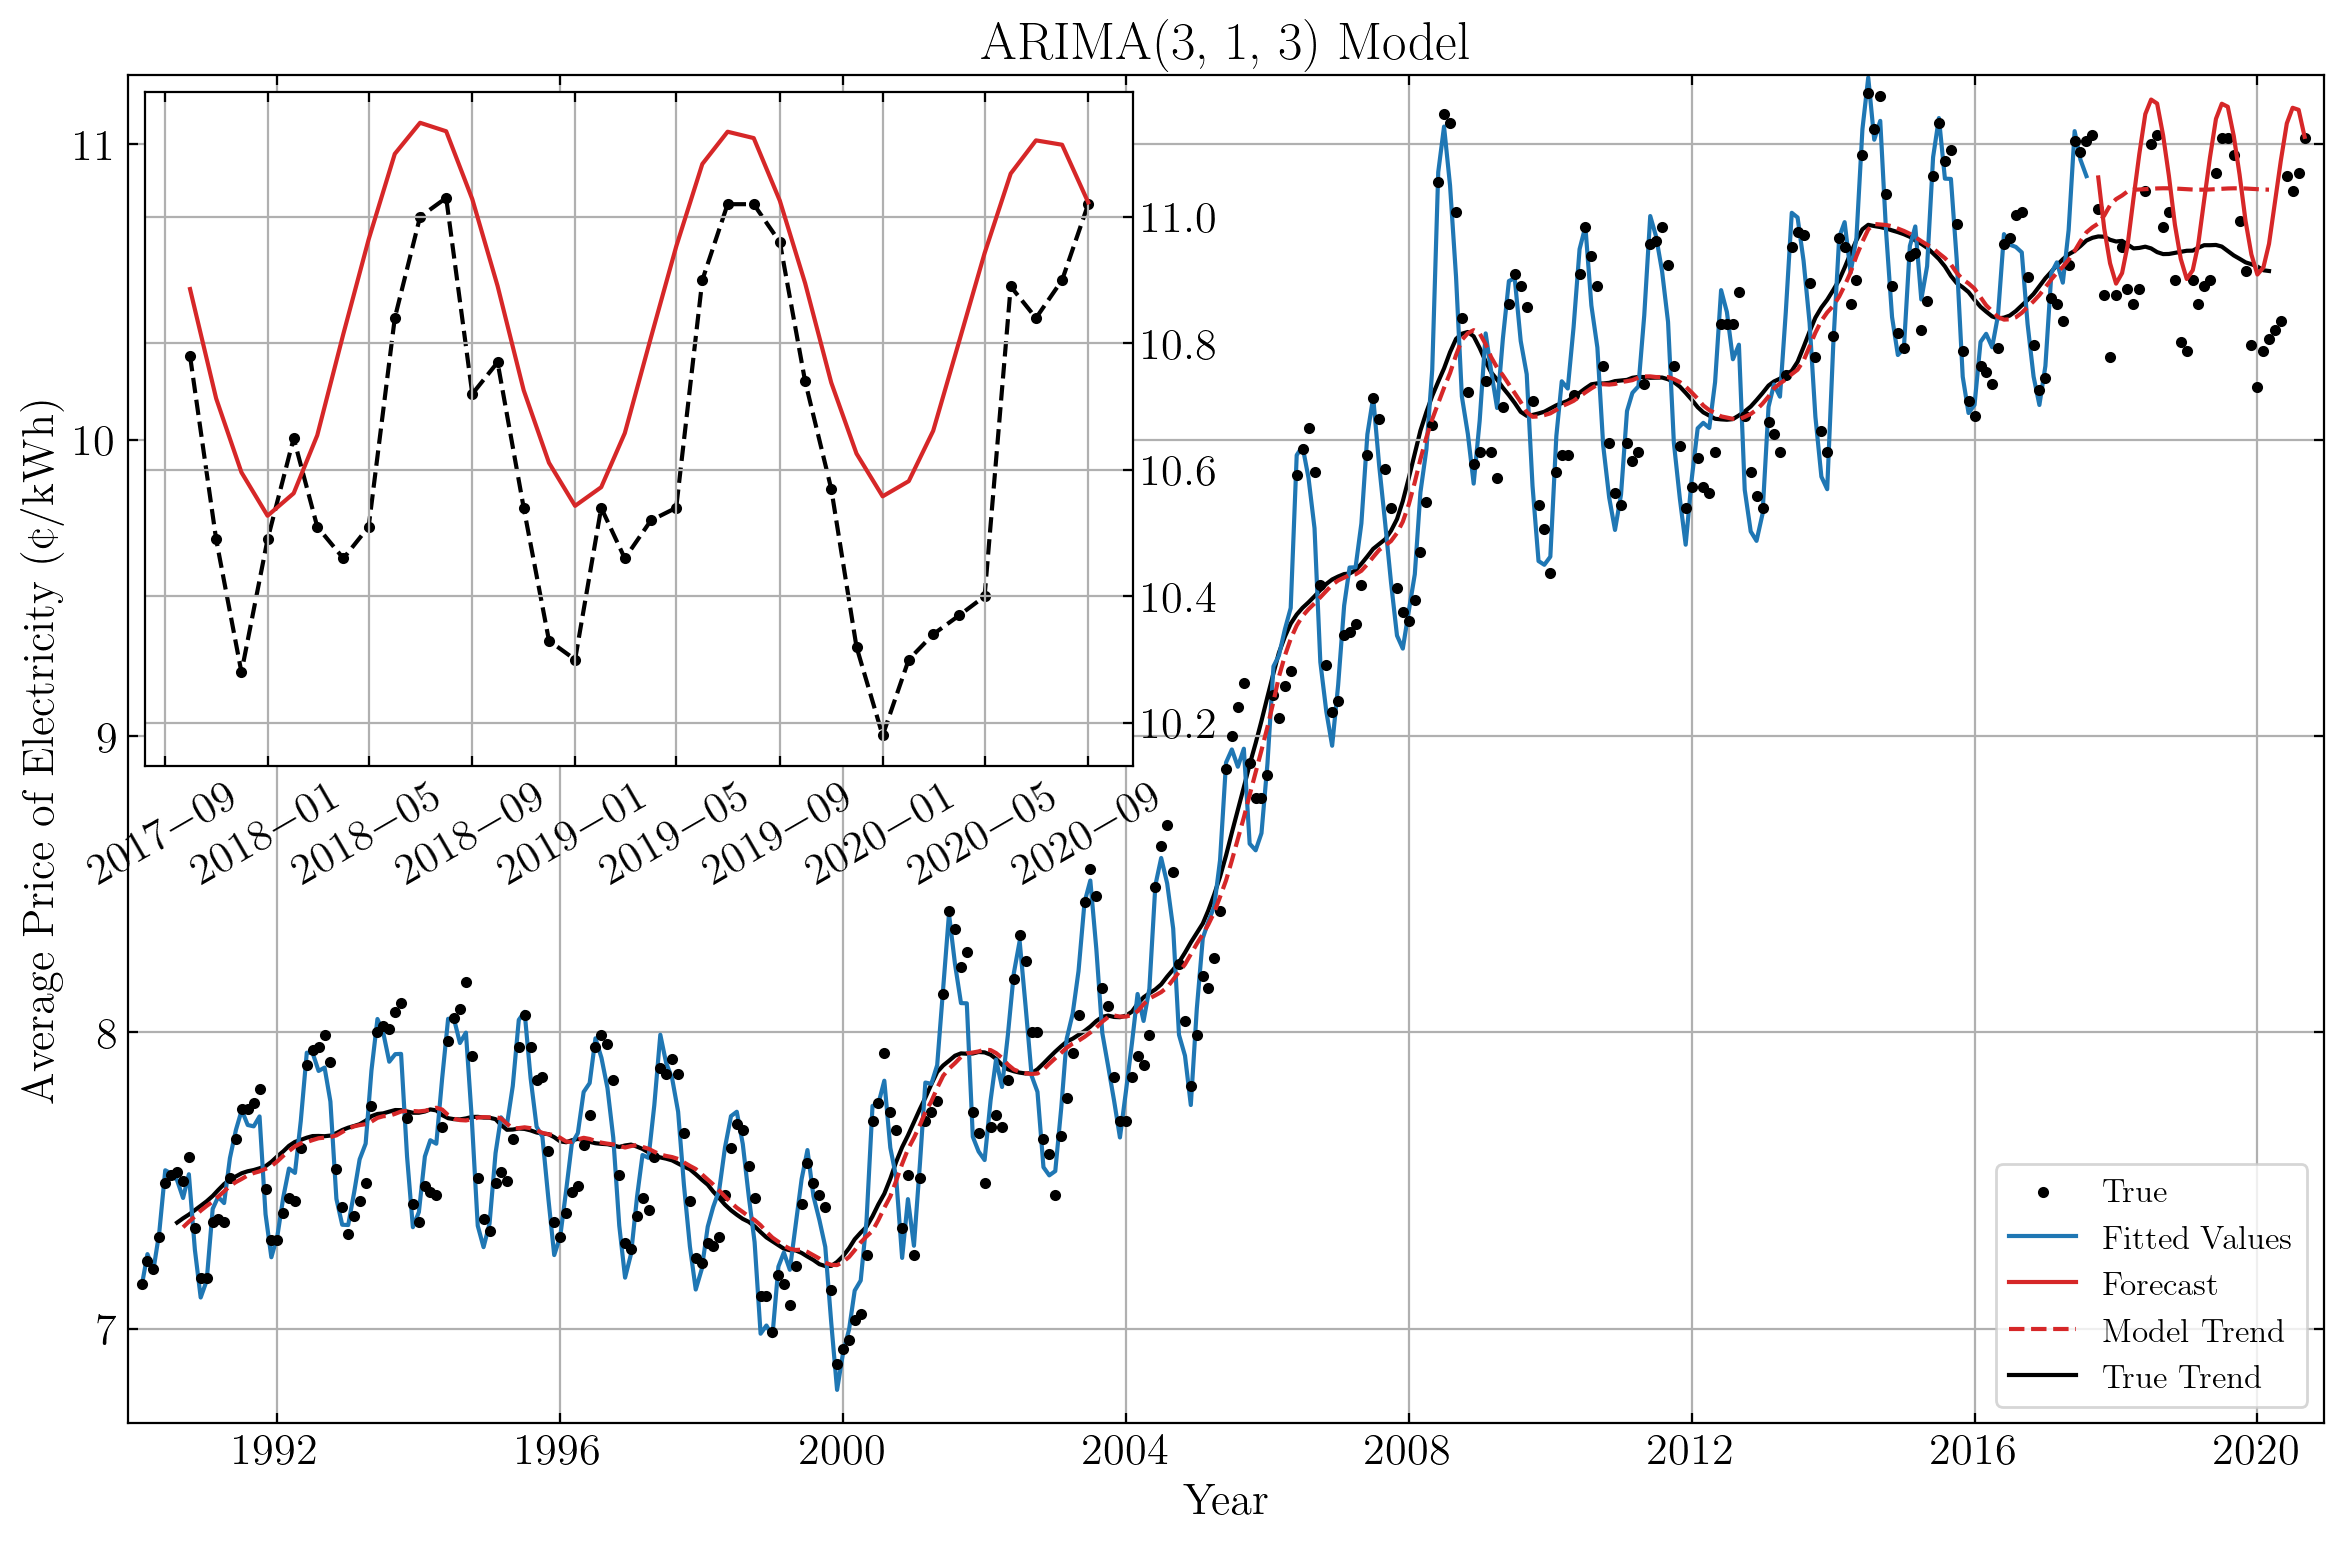

In [14]:
print('MAE: {:.3f}\nRMSE: {:.3f}'.format(
    mean_absolute_error(ytest[:forecast_length], pred_arima),
    root_mean_squared_error(ytest[:forecast_length], pred_arima)
))

# Plot
fig, ax = plt.subplots(1, figsize=(12,8))
ax.scatter(true_vals.index, true_vals.values, label='True', c='k', marker='.', zorder=3)
ax.plot(train.index[:-1], model_arima_fit.fittedvalues[1:], label='Fitted Values', c='C0', zorder=2)
ax.plot(pred_arima, c='C3', ls='-', label='Forecast', zorder=3)
ax.plot(
    seasonal_decompose(pd.concat([model_arima_fit.fittedvalues[1:], pred_arima])).trend, label='Model Trend', c='C3', ls='--', zorder=3
)
ax.plot(trend, label='True Trend', c='k', ls='-', zorder=0)
ax.grid(True)
ax.legend(loc='lower right')
inset = inset_axes(ax, width="45%", height="50%", loc=2)
inset.plot(ytest[:forecast_length], c='k', ls='--', marker='.', zorder=0)
inset.plot(pred_arima, c='C3', ls='-', zorder=3)
inset.grid(visible=True)
inset.yaxis.set_label_position("right")
inset.yaxis.tick_right()
inset.set_xticklabels(labels=inset.get_xticklabels(), rotation=30)
ax.set_xlim(
    train.index[0] - timedelta, test.index[forecast_length] + timedelta
)
ax.set_ylim(ytrain.min()-0.2, ytest[:forecast_length].max()+0.2)
ax.set_title('ARIMA{} Model'.format(model_arima_auto.order))
ax.set_ylabel('Average Price of Electricity (¢/kWh)')
ax.set_xlabel('Year')
plt.tight_layout()
plt.savefig('./figures/arima')
plt.show()

### __SARIMAX Model__

SARIMAX can take exogenous variables as well as y.

In [15]:
model_sarima_auto = auto_arima(y=ytrain, #endogenous data,
                               X=extrain, #exogenous data
                               seasonal=True, #SARIMA
                               m=12, # monthly frequency
                               stationary=False, 
                               trace=True, 
                               )

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-548.389, Time=1.10 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-125.791, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-451.372, Time=0.64 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-292.244, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-127.790, Time=0.11 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-287.627, Time=0.86 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-445.409, Time=0.66 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=-544.695, Time=2.98 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-542.398, Time=3.23 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-183.607, Time=0.24 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=-373.151, Time=2.67 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=-522.427, Time=2.62 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=-545.969, Time=3.22 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=-549.327, Time=1.01 sec
 ARIMA(1,1,2)(0,0,1

In [16]:
# Print best model order
print("Best (p, d, q):", model_sarima_auto.order)
print("Best (P, D, Q, s):", model_sarima_auto.seasonal_order)

Best (p, d, q): (0, 1, 0)
Best (P, D, Q, s): (1, 0, 1, 12)


In [17]:
model_sarima = SARIMAX(
    endog=ytrain,
    exog=extrain,
    order=model_sarima_auto.order,
    seasonal_order=model_sarima_auto.seasonal_order, 
)

model_sarima_fit = model_sarima.fit(disp=False)
print(model_sarima_fit.summary())

pred_sarima = model_sarima_fit.forecast(steps=forecast_length, exog=extest[:forecast_length])

                                      SARIMAX Results                                       
Dep. Variable:                                Price   No. Observations:                  332
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                 283.314
Date:                              Fri, 21 Mar 2025   AIC                           -556.628
Time:                                      15:38:27   BIC                           -537.617
Sample:                                  02-01-1990   HQIC                          -549.046
                                       - 09-01-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Population     0.1416      0.404      0.351      0.726      -0.650       0.933
GDP           -0.00

MAE: 0.069
RMSE: 0.092


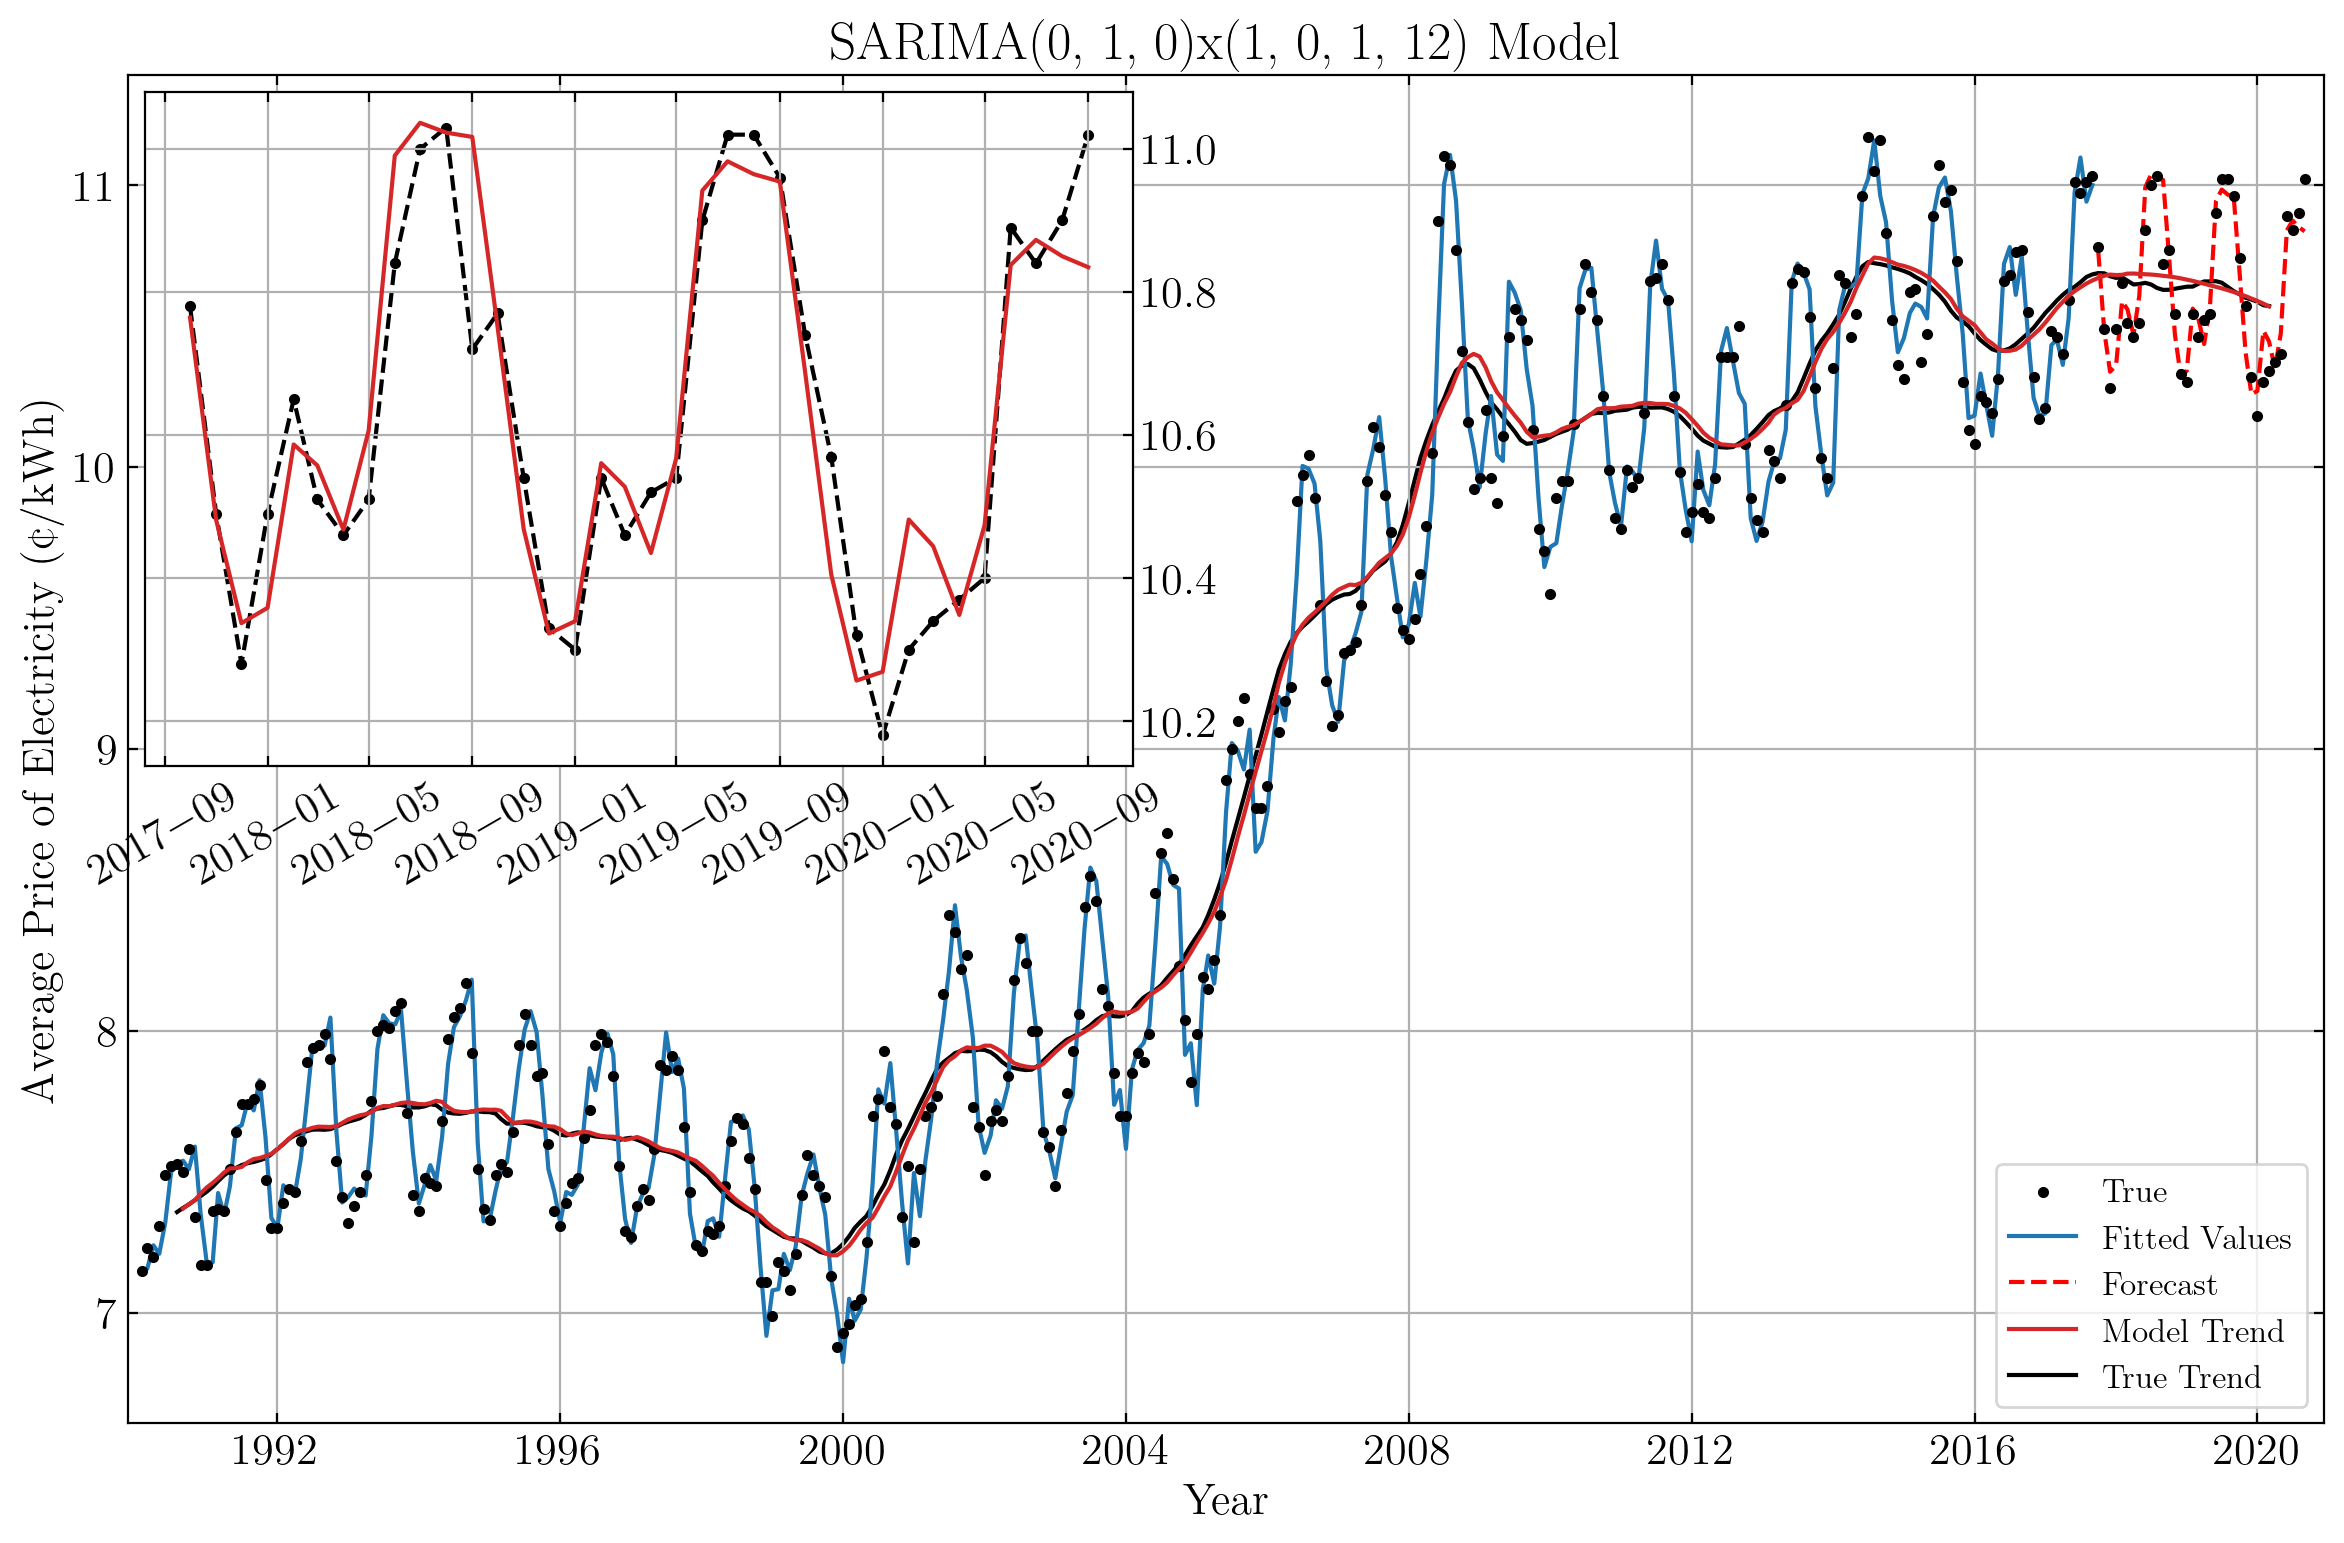

In [18]:
print('MAE: {:.3f}\nRMSE: {:.3f}'.format(
    mean_absolute_error(ytest[:forecast_length], pred_sarima),
    root_mean_squared_error(ytest[:forecast_length], pred_sarima)
))

# Plot
fig, ax = plt.subplots(1, figsize=(12,8))
ax.scatter(
    true_vals.index, true_vals.values, c='k', marker='.', label='True', zorder=3
)
ax.plot(
    model_sarima_fit.fittedvalues[1:], label='Fitted Values', c='C0', zorder=2
)
ax.plot(pred_sarima, c='r', ls='--', label='Forecast')
ax.plot(
    seasonal_decompose(pd.concat([model_sarima_fit.fittedvalues[1:], pred_sarima])).trend, label='Model Trend', c='C3', ls='-', zorder=3
)
ax.plot(trend, label='True Trend', c='k', ls='-', zorder=0)
ax.grid(True)
ax.legend(loc='lower right')
inset = inset_axes(ax, width="45%", height="50%", loc=2)
inset.plot(ytest[:forecast_length], c='k', ls='--', marker='.', zorder=0)
inset.plot(pred_sarima, c='C3', ls='-', zorder=3)
inset.grid(visible=True)
inset.yaxis.set_label_position("right")
inset.yaxis.tick_right()
inset.set_xticklabels(labels=inset.get_xticklabels(), rotation=30)
ax.set_xlim(
    train.index[0] - timedelta, test.index[forecast_length] + timedelta
)
ax.set_title('SARIMA{}x{} Model'.format(
    model_sarima_auto.order, model_sarima_auto.seasonal_order
))
ax.set_ylabel('Average Price of Electricity (¢/kWh)')
ax.set_xlabel('Year')
plt.tight_layout()
plt.savefig('./figures/sarima')
plt.show()

### __VAR Model__

In [19]:
temp_mod = VAR(endog=train)
lag_order = temp_mod.select_order(maxlags=15)
print(lag_order.summary())

best_lag = lag_order.aic
print('Optimal lag order: ', best_lag)

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        7.817       7.876       2481.       7.840
1       -2.544      -2.189     0.07853      -2.402
2       -4.668      -4.016    0.009395      -4.407
3       -5.217      -4.269    0.005423      -4.839
4       -5.634     -4.389*    0.003576      -5.137
5       -5.850      -4.308    0.002886      -5.234
6       -5.985      -4.147    0.002525      -5.250
7       -6.139      -4.005    0.002167      -5.287
8       -6.278      -3.847    0.001892      -5.307
9       -6.439      -3.712    0.001614      -5.350
10      -6.672      -3.648    0.001284      -5.464
11      -6.763      -3.443    0.001177      -5.437
12      -7.148      -3.531   0.0008059      -5.703
13     -7.447*      -3.534  0.0006017*     -5.883*
14      -7.440      -3.230   0.0006107      -5.758
15      -7.437      -2.931   0.0006180      -5.637
-------------------------------

In [20]:
model_var = VAR(endog=train, dates=train.index)

model_var_fit = model_var.fit(maxlags=best_lag)
print(model_var_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 21, Mar, 2025
Time:                     15:38:35
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -3.57885
Nobs:                     319.000    HQIC:                  -5.91835
Log likelihood:          -741.124    FPE:                0.000585192
AIC:                     -7.47387    Det(Omega_mle):     0.000228533
--------------------------------------------------------------------
Results for equation Price
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.225682         0.126220            1.788           0.074
L1.Price                   0.925193         0.060485           15.296           0.000
L1.Renewable               0.540086     

In [21]:
pred_var = model_var_fit.forecast(
    y=train.values[-best_lag:],
    steps=forecast_length,
)

pred_var = pd.DataFrame(pred_var)
pred_var.columns = train.columns
pred_var.index = test.index[:len(pred_var)]

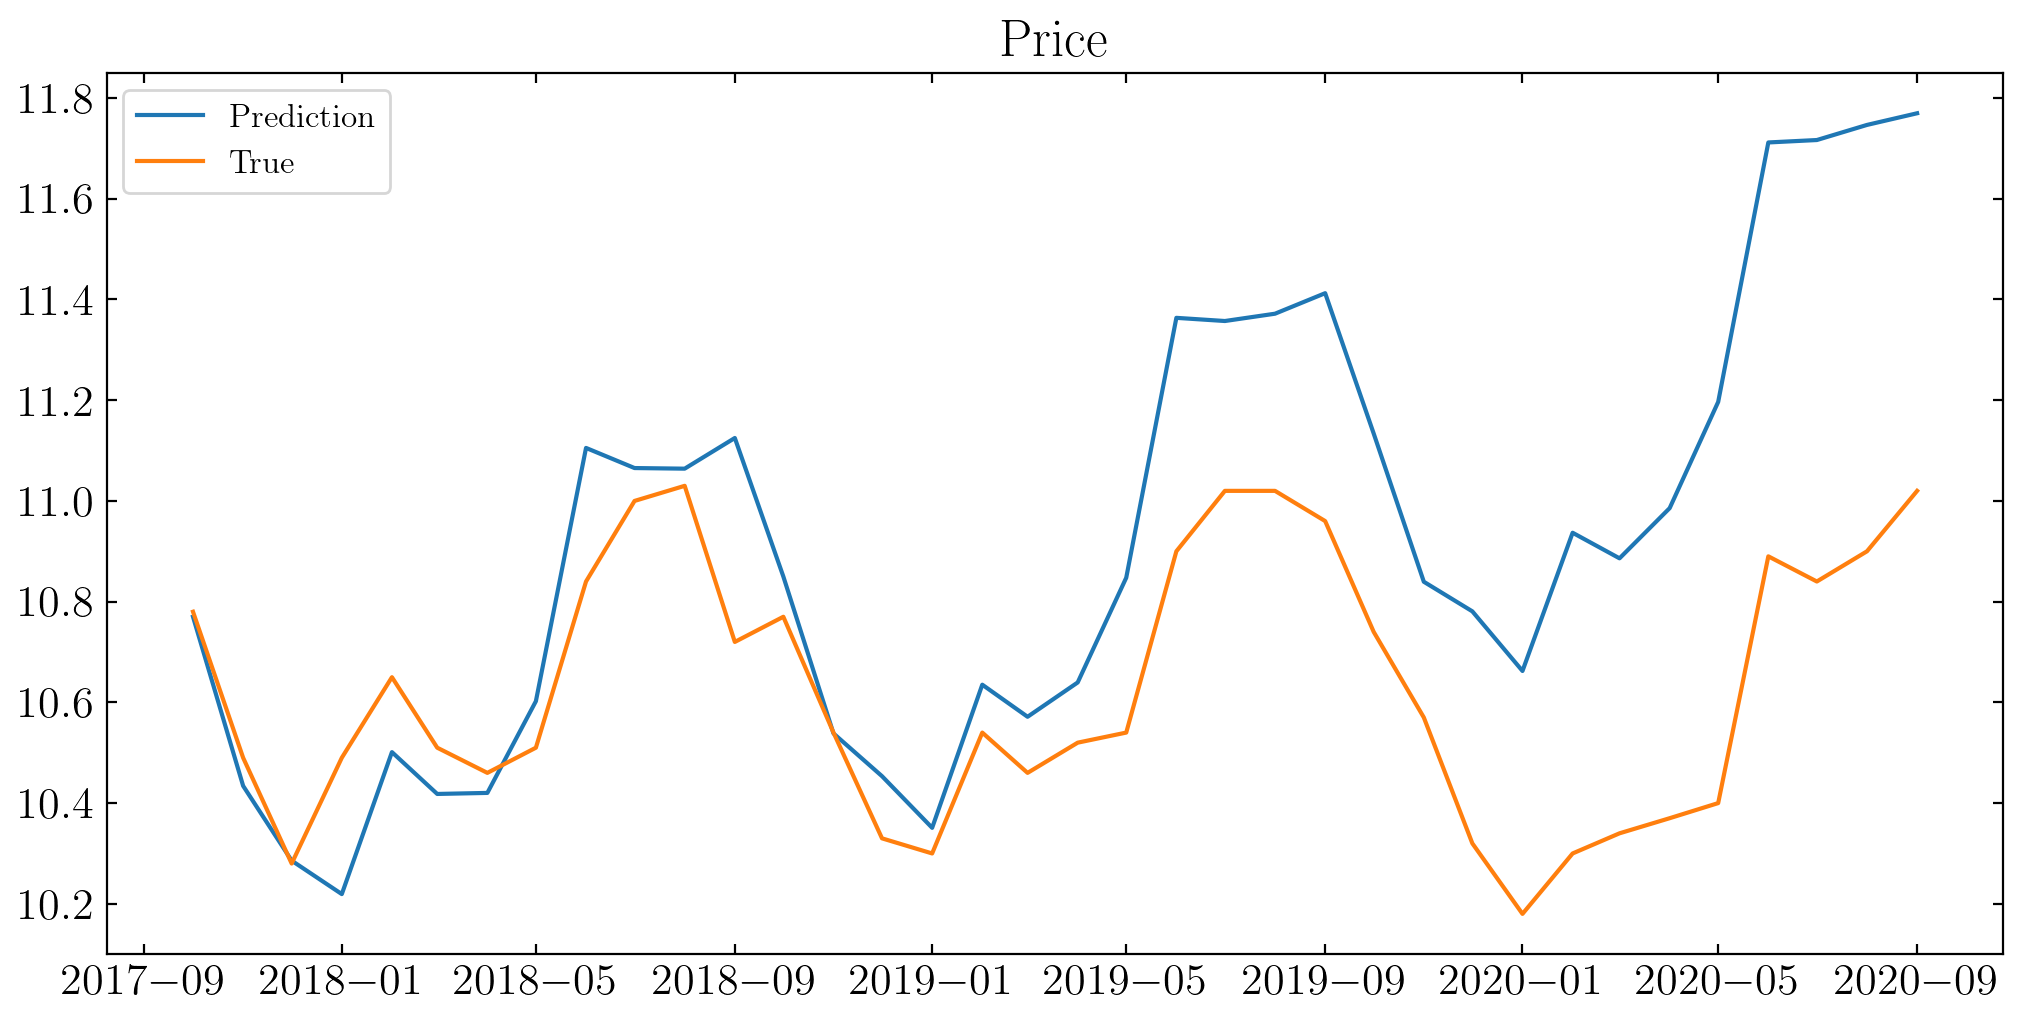

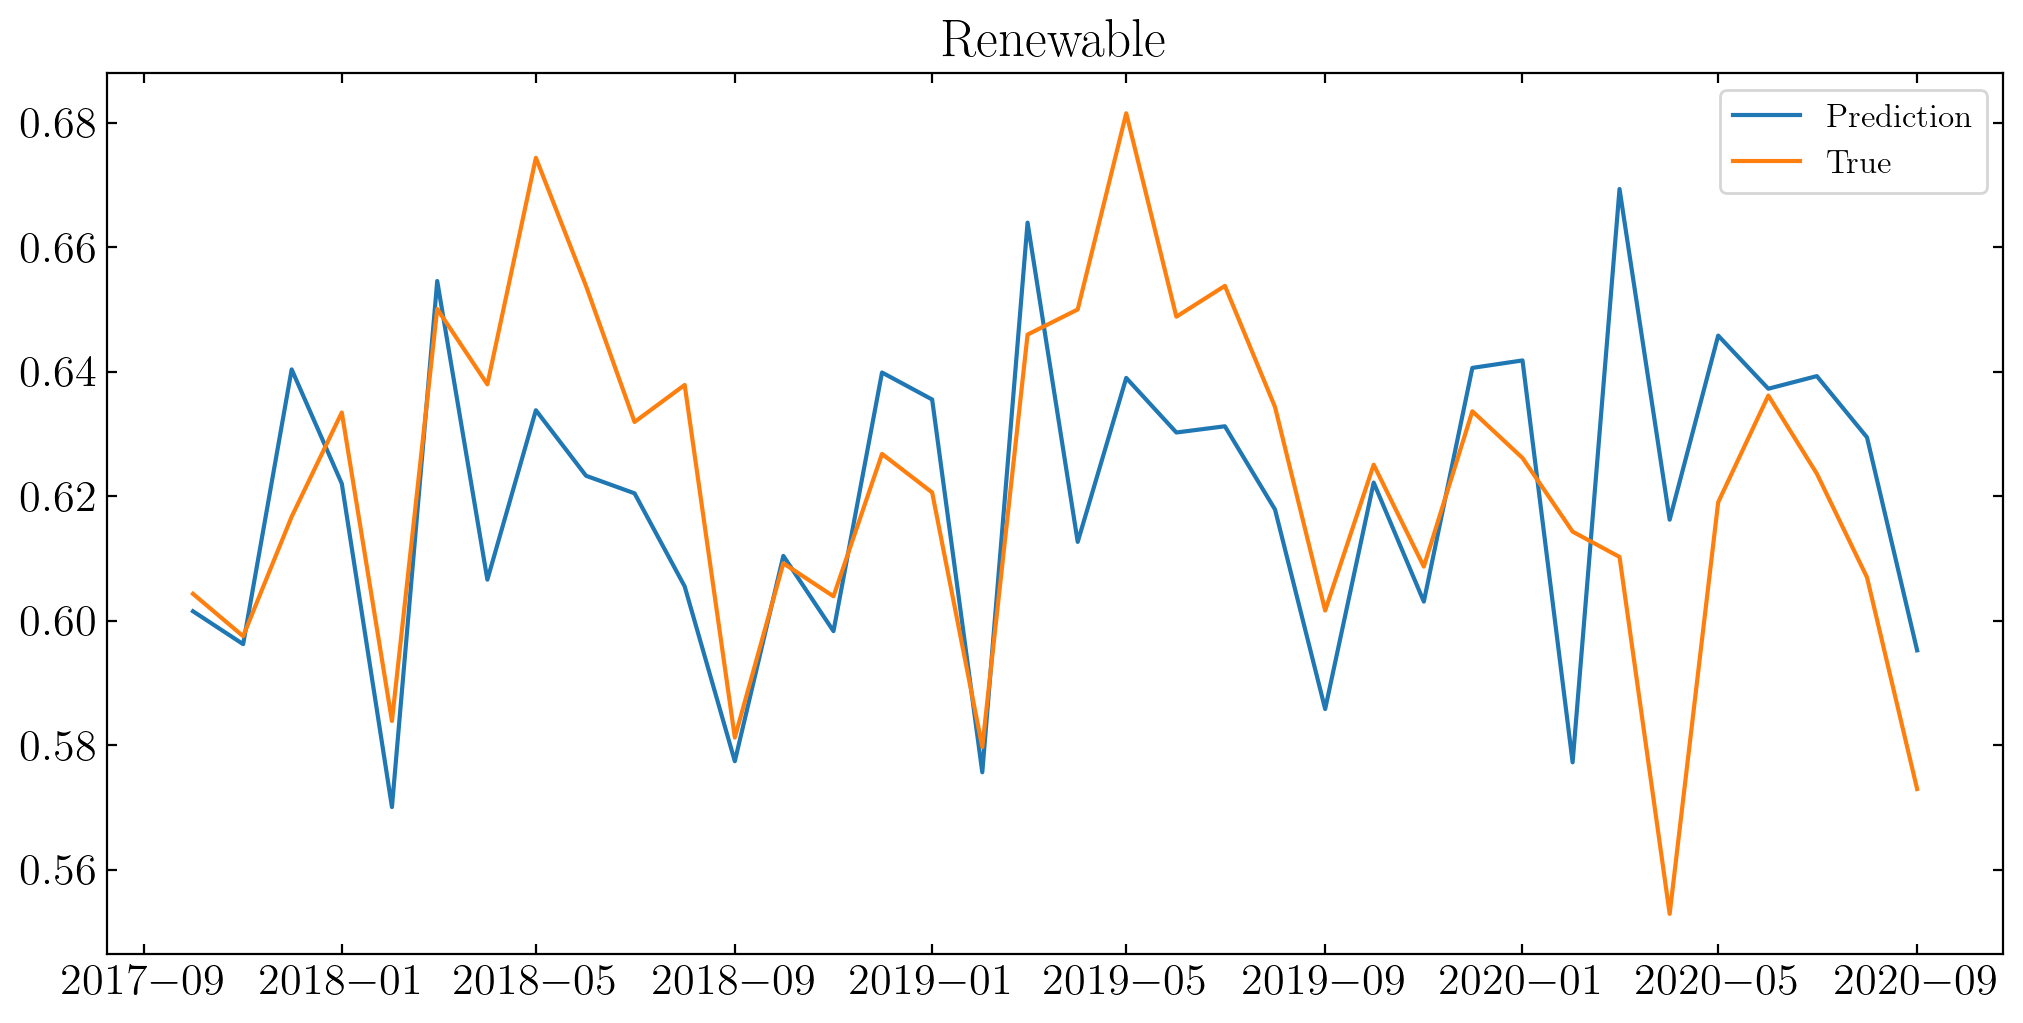

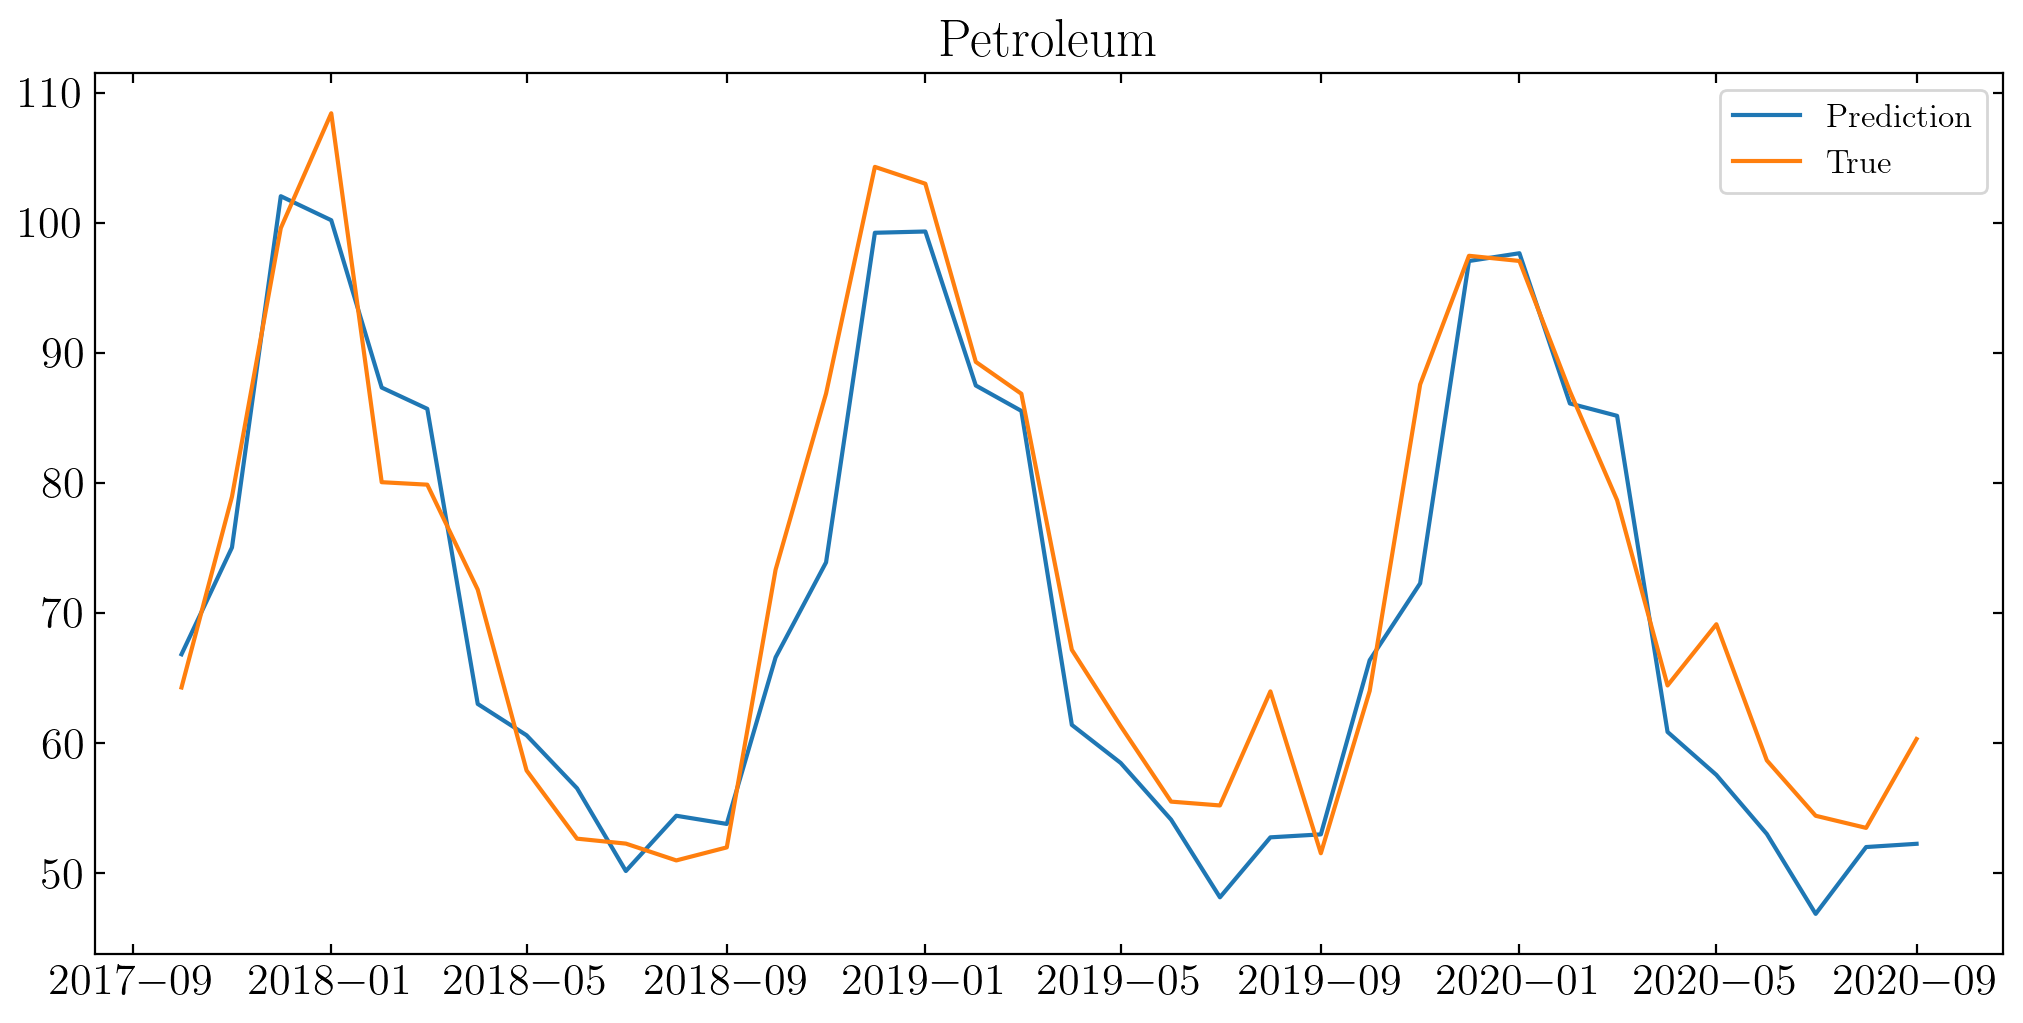

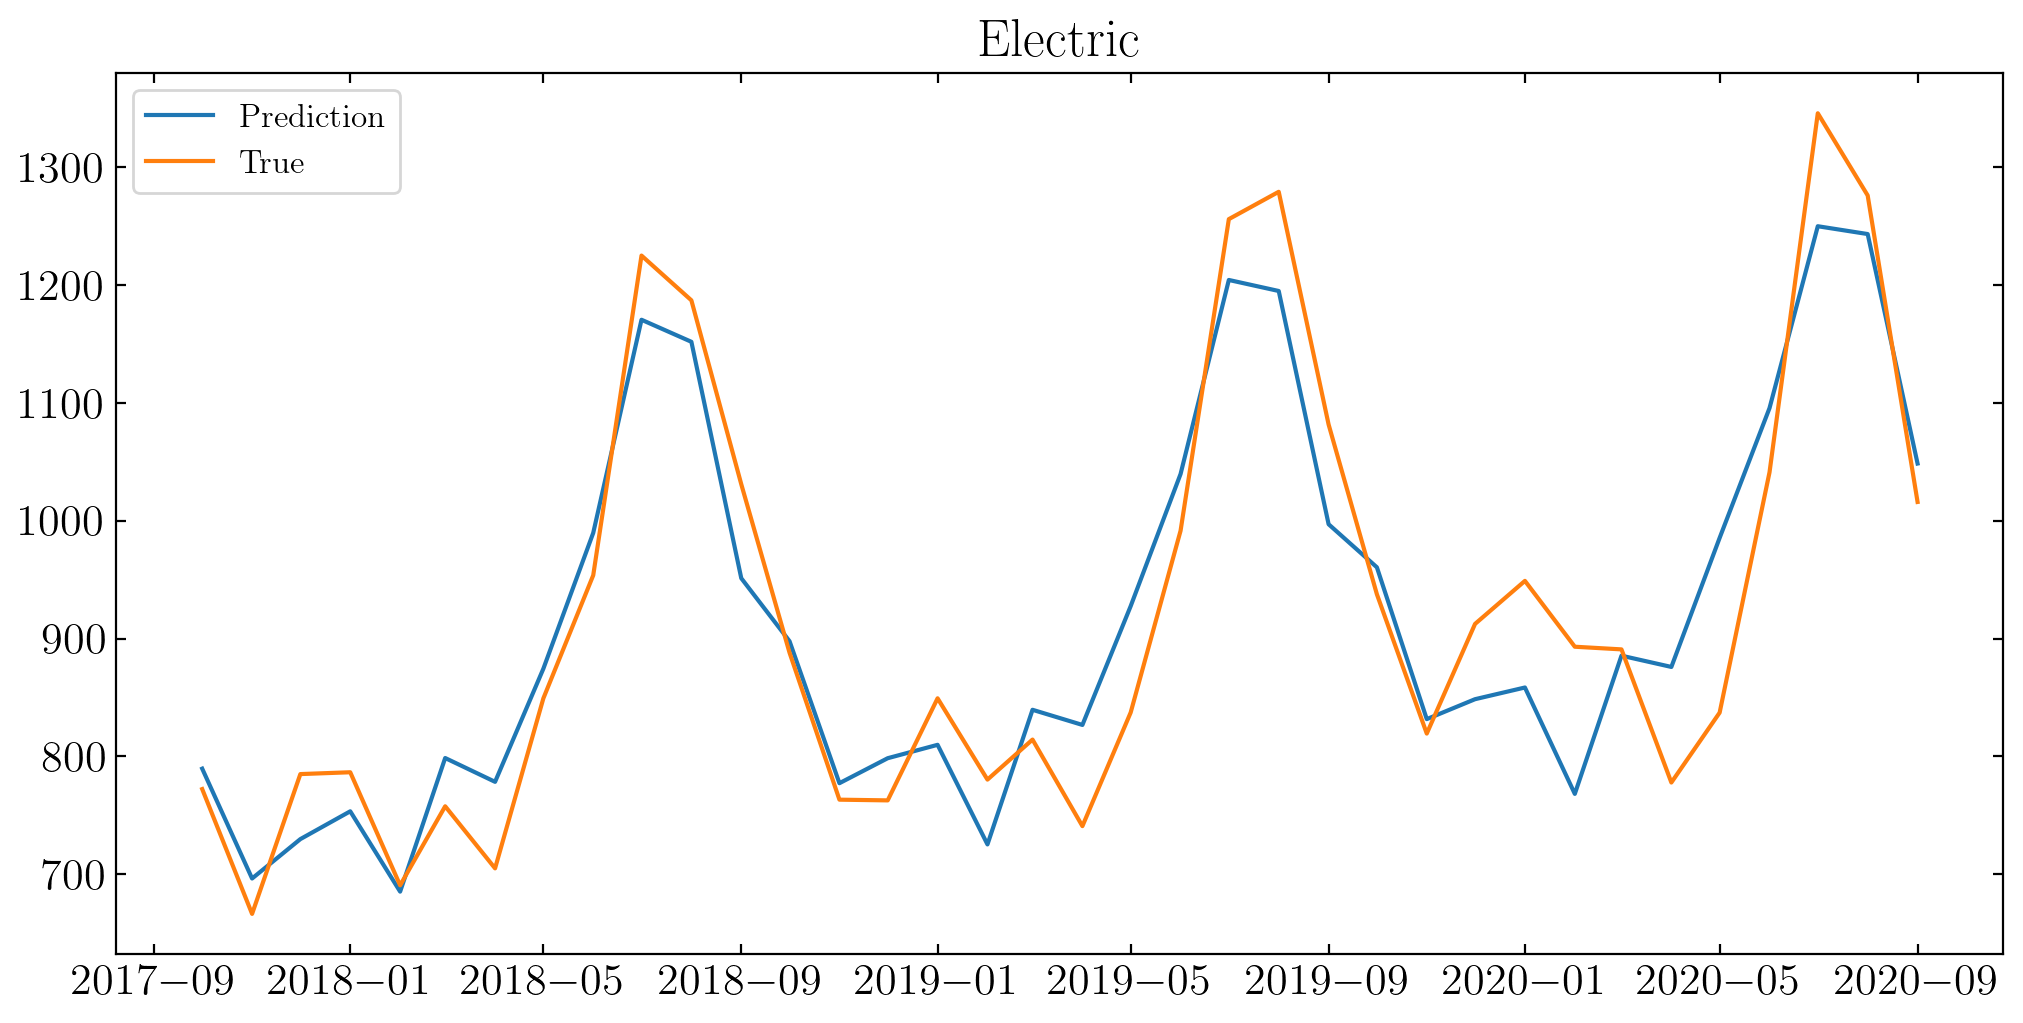

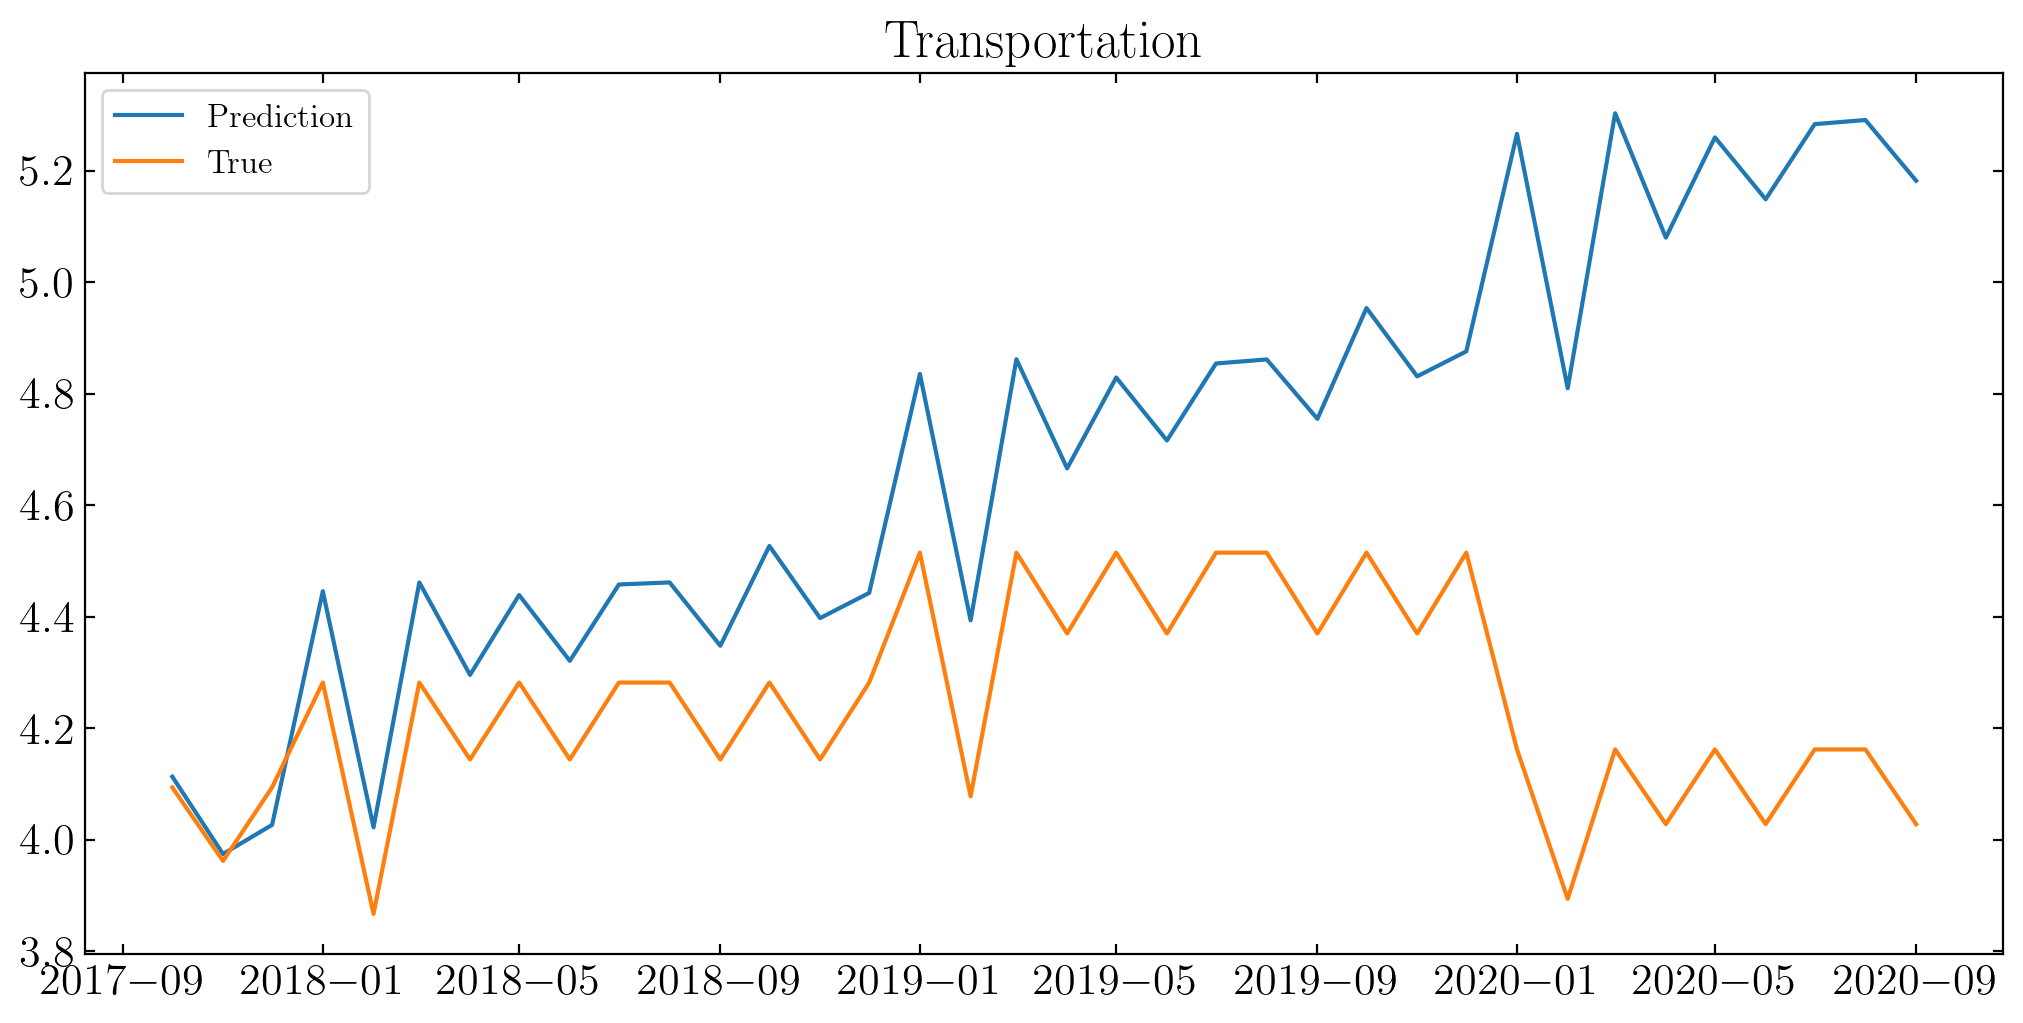

In [22]:
for col in pred_var:
    plt.figure()
    plt.title(col)
    plt.plot(pred_var[col], label='Prediction')
    plt.plot(test[col][:len(pred_var)], label='True')
    plt.legend()
    plt.show()

MAE: 0.319
RMSE: 0.418


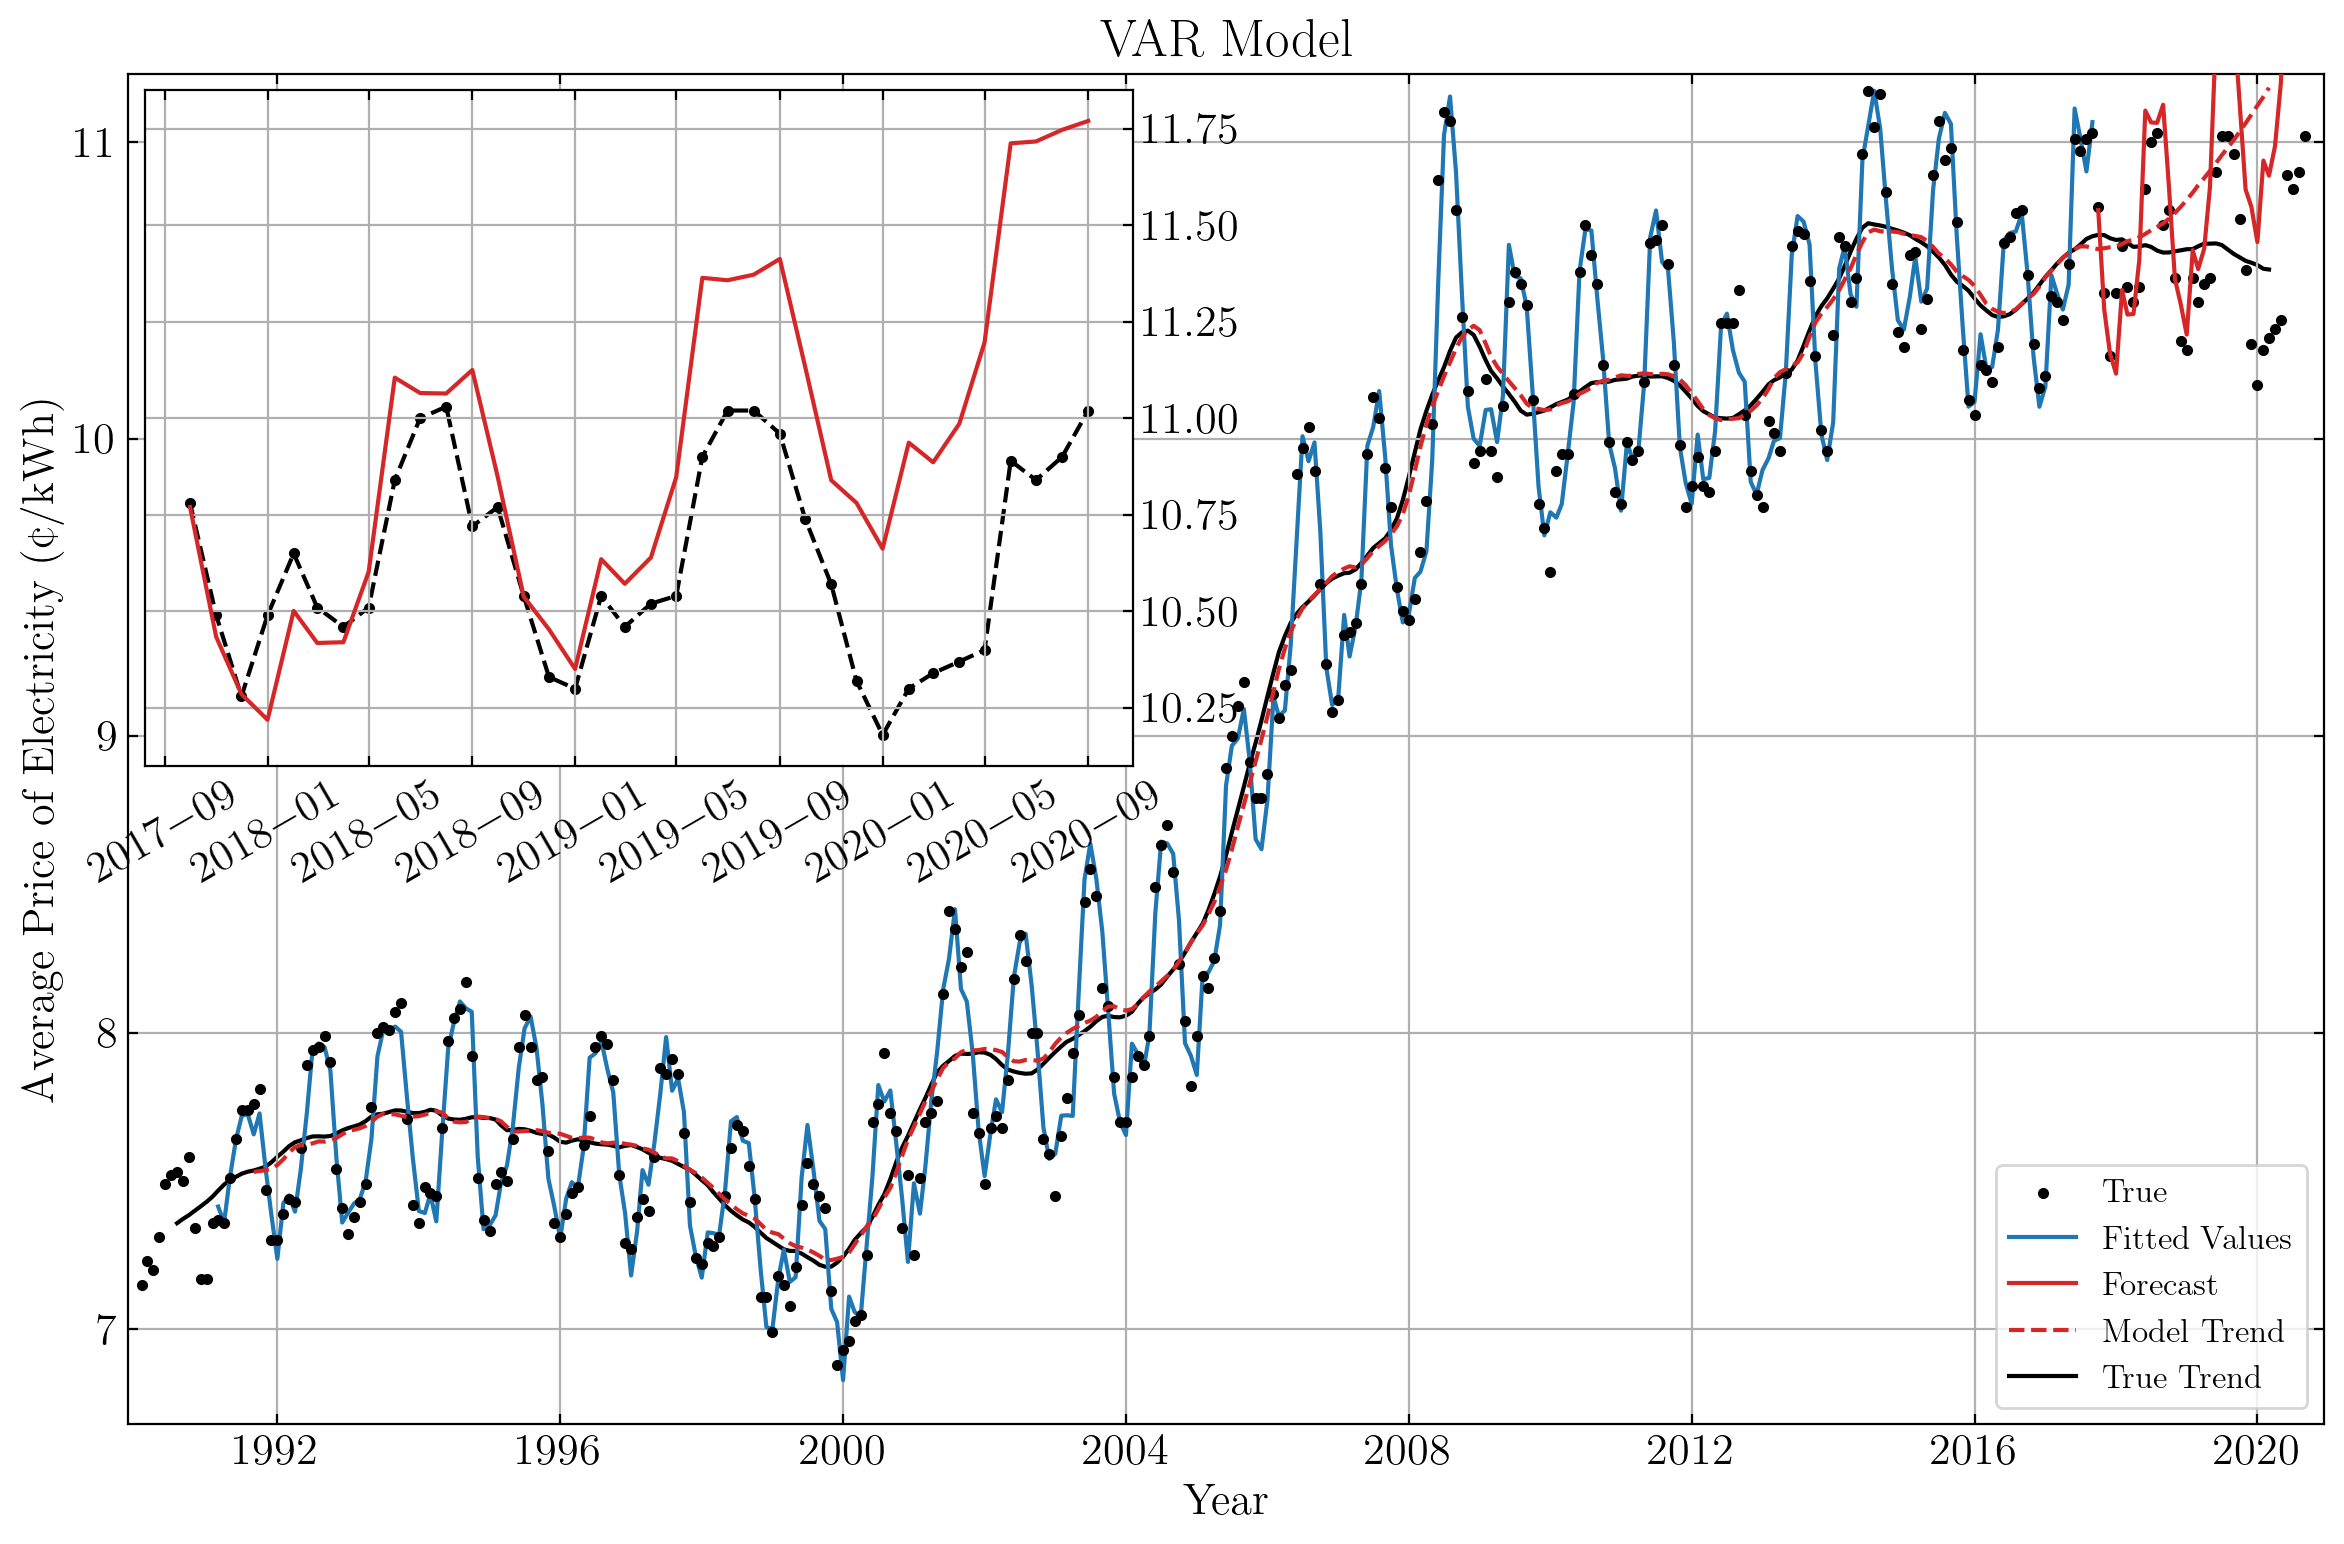

In [23]:
print('MAE: {:.3f}\nRMSE: {:.3f}'.format(
    mean_absolute_error(ytest[:forecast_length], pred_var.Price),
    root_mean_squared_error(ytest[:forecast_length], pred_var.Price)
))

# Plot
fig, ax = plt.subplots(1, figsize=(12,8))
ax.scatter(true_vals.index, true_vals.values, label='True', c='k', marker='.', zorder=3)
ax.plot(model_var_fit.fittedvalues.Price, label='Fitted Values', c='C0', zorder=2)
ax.plot(pred_var.Price, c='C3', ls='-', label='Forecast', zorder=3)
ax.plot(
    seasonal_decompose(pd.concat([model_var_fit.fittedvalues.Price, pred_var.Price])).trend, label='Model Trend', c='C3', ls='--', zorder=3
)
ax.plot(trend, label='True Trend', c='k', ls='-', zorder=0)
ax.grid(True)
ax.legend(loc='lower right')
inset = inset_axes(ax, width="45%", height="50%", loc=2)
inset.plot(ytest[:forecast_length], c='k', ls='--', marker='.', zorder=0)
inset.plot(pred_var.Price, c='C3', zorder=3)
inset.grid(visible=True)
inset.yaxis.set_label_position("right")
inset.yaxis.tick_right()
inset.set_xticklabels(labels=inset.get_xticklabels(), rotation=30)
ax.set_xlim(
    train.index[0] - timedelta, test.index[forecast_length] + timedelta
)
ax.set_ylim(ytrain.min()-0.2, ytest[:forecast_length].max()+0.2)
ax.set_title('VAR Model')
ax.set_ylabel('Average Price of Electricity (¢/kWh)')
ax.set_xlabel('Year')
plt.tight_layout()
plt.savefig('./figures/var')
plt.show()

### __FB Prophet__

I tried setting up grid search and Bayesian optimization, but it was taking literal hours, so I'm just using a standard Prophet model.

15:38:47 - cmdstanpy - INFO - Chain [1] start processing
15:38:47 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 2000x1000 with 0 Axes>

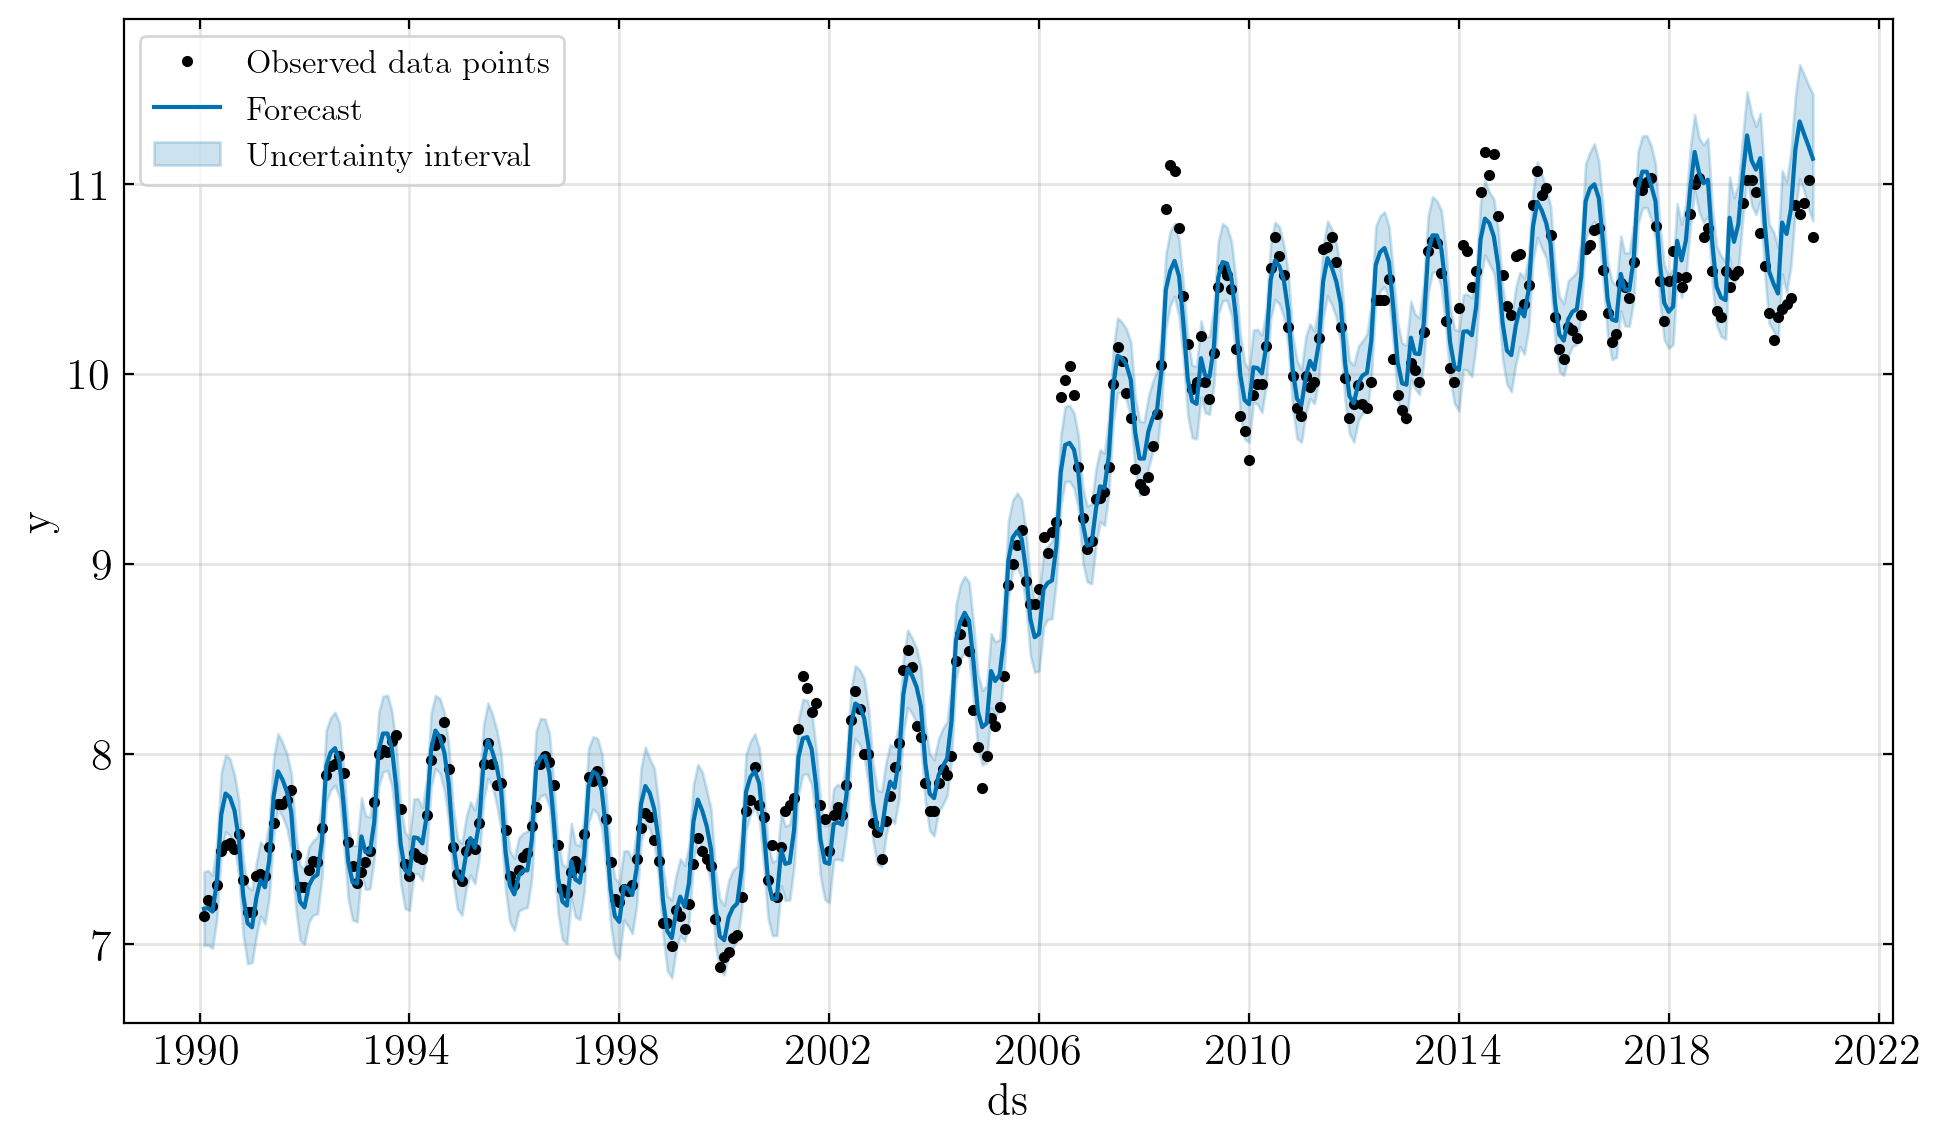

In [24]:
from prophet import Prophet

# New df specifically for FB Prophet
dfproph = pd.DataFrame()
dfproph['ds'] = train.index
dfproph['y'] = train.Price.values

m = Prophet()
m.fit(dfproph)

future = m.make_future_dataframe(periods=forecast_length+1, freq='M')
pred_fb = m.predict(future)

plt.figure()
m.plot(fcst=pred_fb, include_legend=True)
plt.scatter(ytest[:forecast_length+1].index, ytest[:forecast_length+1].values, c='k', marker='.')
plt.show()

<Figure size 2000x1000 with 0 Axes>

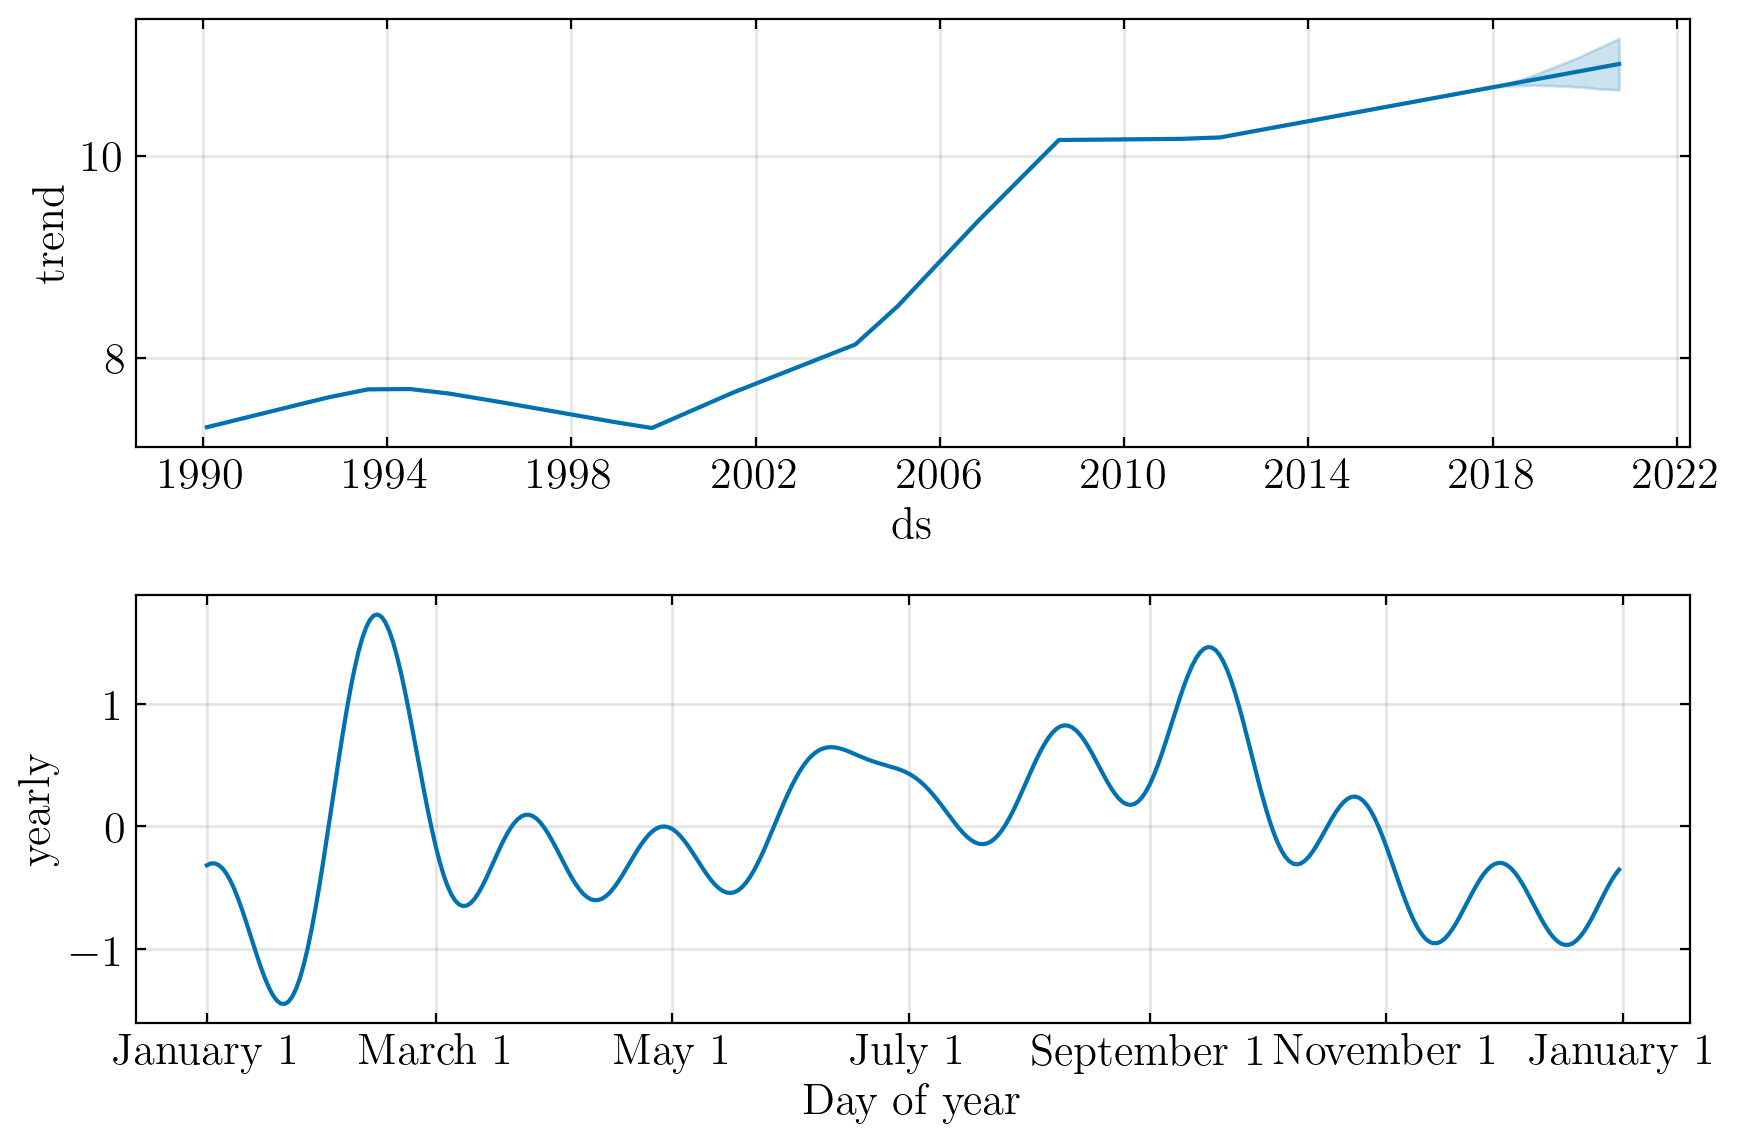

In [25]:
plt.figure()
m.plot_components(fcst=pred_fb)
plt.show()

In [26]:
pred_fb

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   1990-02-01   7.313971    6.992577    7.381612     7.313971     7.313971   
1   1990-03-01   7.322619    6.995369    7.387858     7.322619     7.322619   
2   1990-04-01   7.332194    6.978727    7.362769     7.332194     7.332194   
3   1990-05-01   7.341460    7.130269    7.533173     7.341460     7.341460   
4   1990-06-01   7.351035    7.481743    7.901956     7.351035     7.351035   
..         ...        ...         ...         ...          ...          ...   
364 2020-05-31  10.882225   10.865357   11.461906    10.661338    11.091228   
365 2020-06-30  10.889117   11.025607   11.628102    10.660226    11.111222   
366 2020-07-31  10.896238   10.962051   11.576186    10.658233    11.128907   
367 2020-08-31  10.903359   10.869582   11.520492    10.655051    11.145593   
368 2020-09-30  10.910250   10.805504   11.473401    10.652948    11.163073   

     additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0         -0.128251             -0.128251             -0.128251 -0.128251   
1         -0.132631             -0.132631             -0.132631 -0.132631   
2         -0.160712             -0.160712             -0.160712 -0.160712   
3         -0.017633             -0.017633             -0.017633 -0.017633   
4          0.330349              0.330349              0.330349  0.330349   
..              ...                   ...                   ...       ...   
364        0.297866              0.297866              0.297866  0.297866   
365        0.440130              0.440130              0.440130  0.440130   
366        0.365923              0.365923              0.365923  0.365923   
367        0.295483              0.295483              0.295483  0.295483   
368        0.222514              0.222514              0.222514  0.222514   

     yearly_lower  yearly_upper  multiplicative_terms  \
0       -0.128251     -0.128251                   0.0   
1       -0.132631     -0.132631                   0.0   
2       -0.160712     -0.160712                   0.0   
3       -0.017633     -0.017633                   0.0   
4        0.330349      0.330349                   0.0   
..            ...           ...                   ...   
364      0.297866      0.297866                   0.0   
365      0.440130      0.440130                   0.0   
366      0.365923      0.365923                   0.0   
367      0.295483      0.295483                   0.0   
368      0.222514      0.222514                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper       yhat  
0                           0.0                         0.0   7.185719  
1                           0.0                         0.0   7.189988  
2                           0.0                         0.0   7.171482  
3                           0.0                         0.0   7.323827  
4                           0.0                         0.0   7.681384  
..                          ...                         ...        ...  
364                         0.0                         0.0  11.180091  
365                         0.0                         0.0  11.329247  
366                         0.0                         0.0  11.262161  
367                         0.0                         0.0  11.198842  
368                         0.0                         0.0  11.132764  

[369 rows x 16 columns]

In [27]:
pred_fb.set_index('ds', inplace=True)

MAE: 0.230
RMSE: 0.291


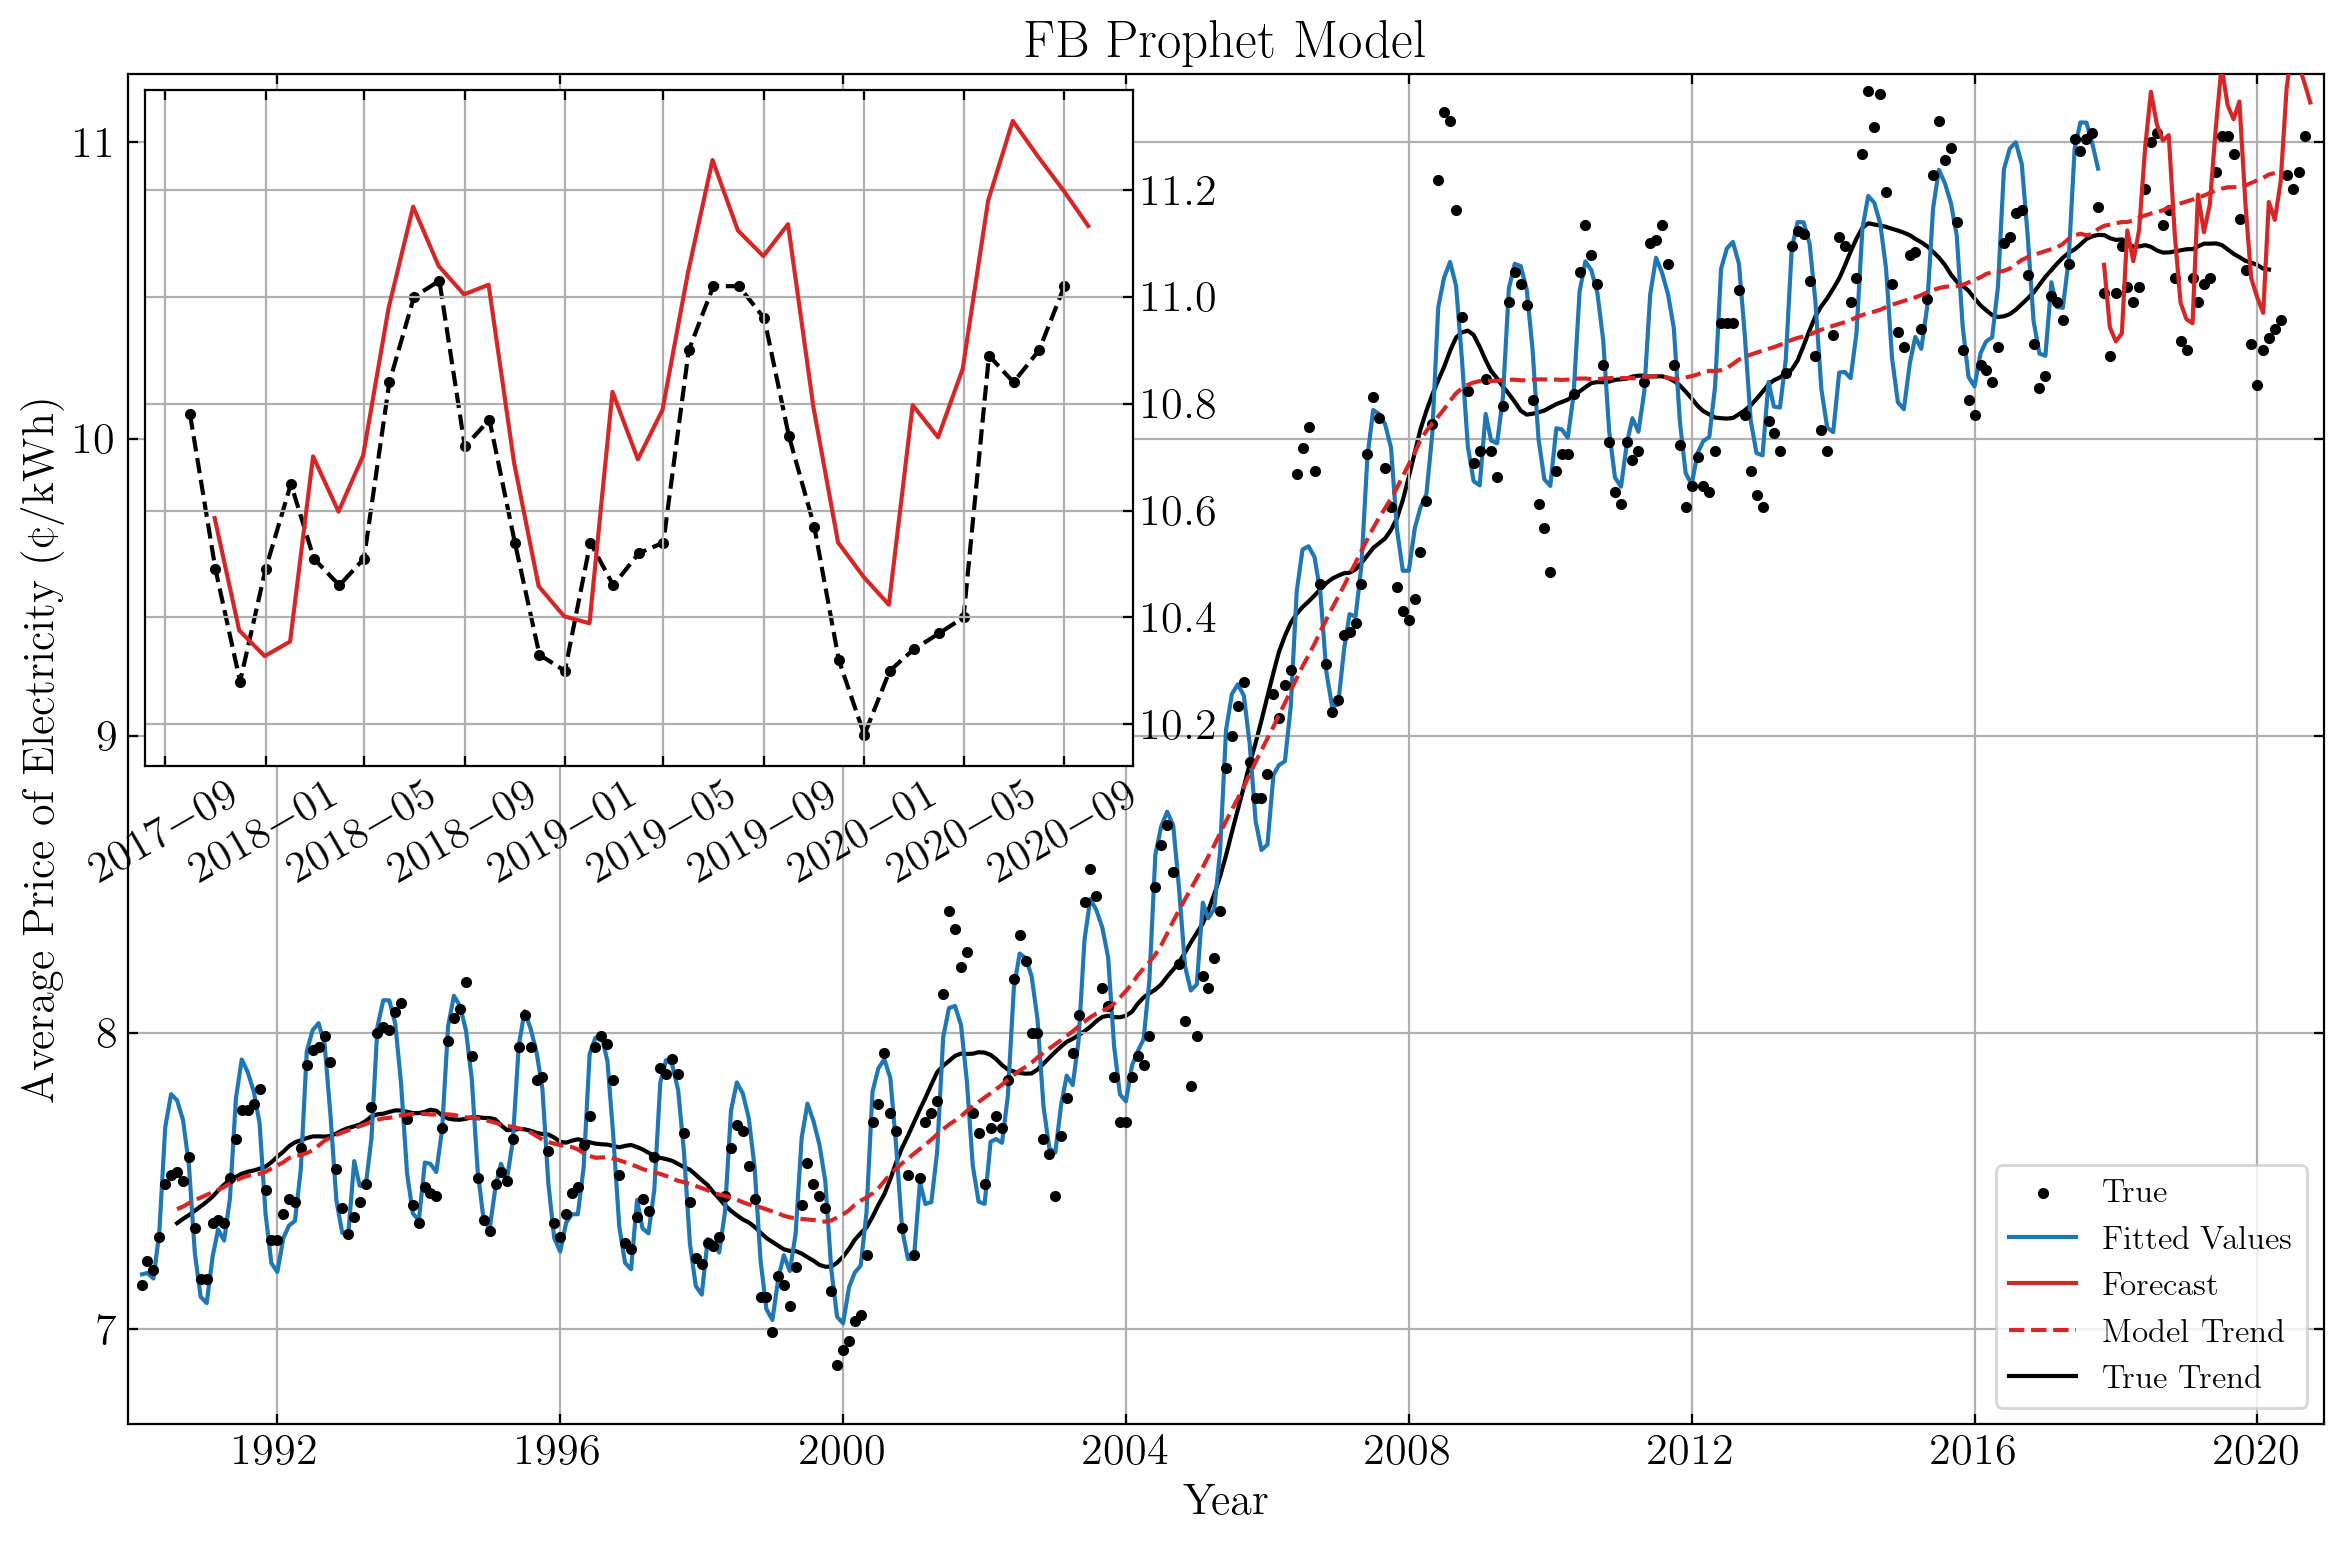

In [28]:
print('MAE: {:.3f}\nRMSE: {:.3f}'.format(
    mean_absolute_error(ytest[:forecast_length], pred_fb.yhat[splitdate:]),
    root_mean_squared_error(ytest[:forecast_length], pred_fb.yhat[splitdate:])
))

# Plot
fig, ax = plt.subplots(1, figsize=(12,8))
ax.scatter(true_vals.index, true_vals.values, label='True', c='k', marker='.', zorder=3)
ax.plot(pred_fb.yhat[:splitdate], label='Fitted Values', c='C0', zorder=2)
ax.plot(pred_fb.yhat[splitdate:], c='C3', ls='-', label='Forecast', zorder=3)
ax.plot(
    seasonal_decompose(x=pred_fb.yhat, period=12).trend, label='Model Trend', c='C3', ls='--', zorder=3
)
ax.plot(trend, label='True Trend', c='k', ls='-', zorder=0)
ax.grid(True)
ax.legend(loc='lower right')
inset = inset_axes(ax, width="45%", height="50%", loc=2)
inset.plot(ytest[:forecast_length], c='k', ls='--', marker='.', zorder=0)
inset.plot(pred_fb.yhat[splitdate:], c='C3', ls='-', zorder=3)
inset.grid(visible=True)
inset.yaxis.set_label_position("right")
inset.yaxis.tick_right()
inset.set_xticklabels(labels=inset.get_xticklabels(), rotation=30)
ax.set_xlim(
    train.index[0] - timedelta, test.index[forecast_length] + timedelta
)
ax.set_title('FB Prophet Model')
ax.set_ylim(ytrain.min()-0.2, ytest[:forecast_length].max()+0.2)
ax.set_ylabel('Average Price of Electricity (¢/kWh)')
ax.set_xlabel('Year')
plt.tight_layout()
plt.savefig('./figures/fbprophet')
plt.show()

### __Exponential Smoothing__

In [29]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [30]:
# Grid search for best Exp Smoothing params
import itertools

trend_options = [None, "add", "mul"]
seasonal_options = [None, "add", "mul"]
best_score, best_cfg = float("inf"), None

for trend, seasonal in itertools.product(trend_options, seasonal_options):
    try:
        model = ExponentialSmoothing(ytrain, trend=trend, seasonal=seasonal, seasonal_periods=12)
        model_fit = model.fit()
        rmse = np.sqrt(mean_squared_error(ytest[:forecast_length], model_fit.forecast(forecast_length)))
        if rmse < best_score:
            best_score, best_cfg = rmse, (trend, seasonal)
    except:
        continue

print(f"Best config: {best_cfg} with RMSE {best_score}")

Best config: (None, 'add') with RMSE 0.13306347196525686


In [31]:
# Define the Holt-Winters model
model_es = ExponentialSmoothing(ytrain, 
                             trend=best_cfg[0],  # best performing trend
                             seasonal=best_cfg[1],  # best performing season
                             seasonal_periods=12,   # monthly seasonality
                             )  

# Fit the model
model_es_fit = model_es.fit()
print(model_es_fit.summary())

# Forecast the next test period
pred_es = model_es_fit.forecast(steps=forecast_length)

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Price   No. Observations:                  332
Model:             ExponentialSmoothing   SSE                              3.574
Optimized:                         True   AIC                          -1476.395
Trend:                             None   BIC                          -1423.123
Seasonal:                      Additive   AICC                         -1474.668
Seasonal Periods:                    12   Date:                 Fri, 21 Mar 2025
Box-Cox:                          False   Time:                         15:38:53
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.8027161                alpha                 True
smoothing_seasonal       

MAE: 0.110
RMSE: 0.133


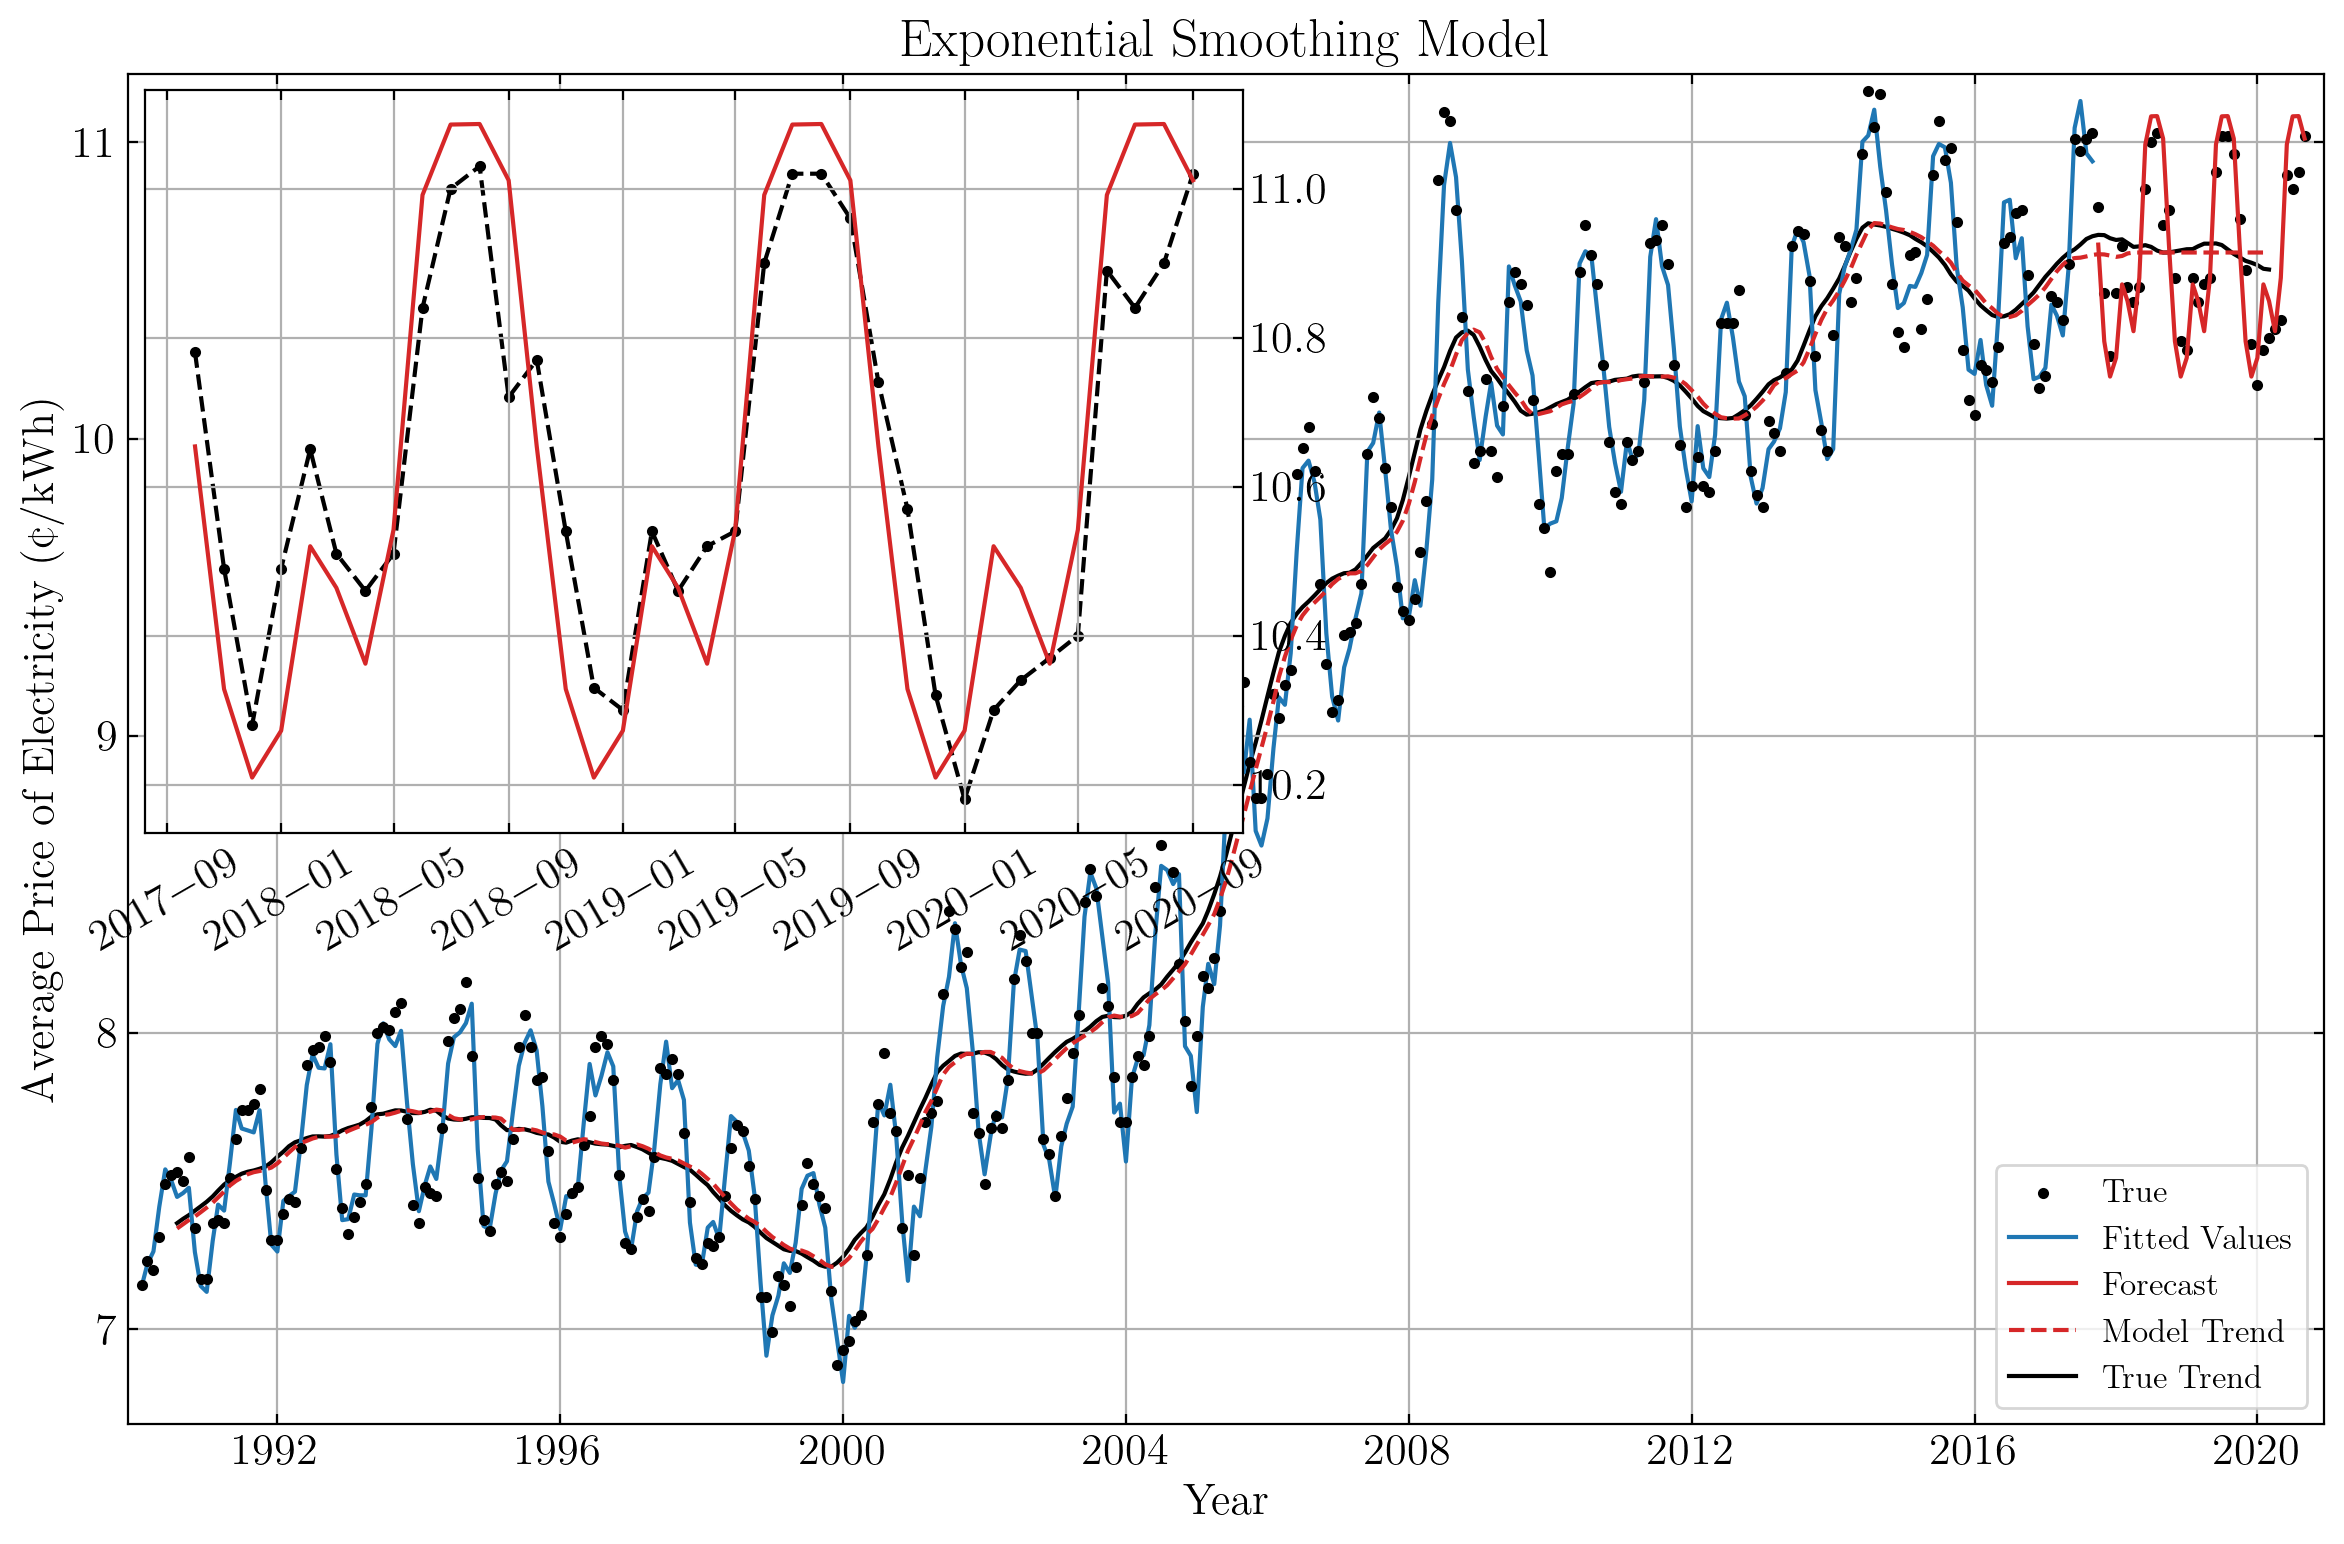

In [32]:
print('MAE: {:.3f}\nRMSE: {:.3f}'.format(
    mean_absolute_error(ytest[:forecast_length], pred_es),
    root_mean_squared_error(ytest[:forecast_length], pred_es)
))

# Plot
fig, ax = plt.subplots(1, figsize=(12,8))
ax.scatter(true_vals.index, true_vals.values, label='True', c='k', marker='.', zorder=3)
ax.plot(model_es_fit.fittedvalues, label='Fitted Values', c='C0', zorder=2)
ax.plot(pred_es, c='C3', ls='-', label='Forecast', zorder=3)
ax.plot(
    seasonal_decompose(pd.concat([model_es_fit.fittedvalues, pred_es])).trend, label='Model Trend', c='C3', ls='--', zorder=3
)
trend = seasonal_decompose(df.Price[:len(ytrain)+forecast_length]).trend
ax.plot(trend, label='True Trend', c='k', ls='-', zorder=0)
ax.grid(True)
ax.legend(loc='lower right')
inset = inset_axes(ax, width="50%", height="55%", loc=2)
inset.plot(ytest[:forecast_length], c='k', ls='--', marker='.', zorder=0)
inset.plot(pred_es, c='C3', ls='-', zorder=3)
inset.grid(visible=True)
inset.yaxis.set_label_position("right")
inset.yaxis.tick_right()
inset.set_xticklabels(labels=inset.get_xticklabels(), rotation=30)
ax.set_xlim(
    train.index[0] - timedelta, test.index[forecast_length] + timedelta
)
ax.set_ylim(ytrain.min()-0.2, ytest[:forecast_length].max()+0.2)
ax.set_ylabel('Average Price of Electricity (¢/kWh)')
ax.set_xlabel('Year')
ax.set_title('Exponential Smoothing Model')
plt.tight_layout()
plt.savefig('./figures/expsmoothing')
plt.show()

We know our data has a trend, so this model is likely overfitting to the data because it's forecasting a section without a noticeable trend.

### __One Step Ahead Cross Validation__

In [33]:
# General, naive benchmark for comparing model RMSE
y_pred_naive = ytrain.rolling(window=len(ytrain)-len(ytest)+1).mean().shift(-1)
rmse_naive = np.sqrt(mean_squared_error(ytest, y_pred_naive.dropna()))
print(rmse_naive)

2.904044043944934


In [34]:
# Train size
train_size = split

# One step ahead cross validation
def one_step_ahead_cv(model_class, model_params, y, exog=None, train_size=train_size):
    """
    Perform rolling-origin one-step-ahead cross-validation.
    
    Parameters:
        model_class: The forecasting model class (works for ARIMA, SARIMAX, ES)
        model_params: Dictionary of parameters for the model.
        y: Time series data.
        exog: Exogenous data
        train_size: Proportion of data to use for initial training.

    Returns:
        y_test: Actual test values.
        predictions: Model forecasts.
    """


    train_len = int(len(y) * train_size)
    train, test = y[:train_len], y[train_len:]
    
    history = list(train)  # Start with initial training set
    predictions = []
    
    for t in range(len(test)):
        # Fit model on the current history
        if exog is None:
            model = model_class(history, **model_params).fit()
            forecast = model.forecast(steps=1)[0]
        else:
            model = model_class(history, exog=exog[:len(history)].values, **model_params).fit(disp=False)
            forecast = model.forecast(steps=1, exog=exog[len(history):len(history)+1].values)[0]
        

        predictions.append(forecast)
        # Add true value to training set (walk-forward validation)
        history.append(test.iloc[t])

    return test, predictions

#### __ARIMA__

In [35]:
# Define ARIMA model parameters
arima_params = {"order": model_arima_auto.order}

# Run one-step-ahead validation
y_test, arima_preds = one_step_ahead_cv(ARIMA, arima_params, df.Price, train_size=train_size)

# Compute performance
mae = mean_absolute_error(y_test, arima_preds)
rmse = np.sqrt(mean_squared_error(y_test, arima_preds))
print(f"ARIMA MAE: {mae:.4f}, RMSE: {rmse:.4f}")

ARIMA MAE: 0.1776, RMSE: 0.2421


#### __SARIMAX__

In [36]:
# SARIMAX Params
sarima_params = {"order":model_sarima_auto.order,
                 "seasonal_order":model_sarima_auto.seasonal_order,
                 }

# Run CV
y_test, sarima_preds = one_step_ahead_cv(
    SARIMAX, sarima_params, df.Price, exog=exog, train_size=train_size,
)

mae = mean_absolute_error(y_test, sarima_preds)
rmse = root_mean_squared_error(y_test, sarima_preds)
print(f"SARIMAX MAE: {mae:.4f}, RMSE: {rmse:.4f}")

SARIMAX MAE: 0.1334, RMSE: 0.1894


#### __Exponential Smoothing__

In [37]:
# Define Exponential Smoothing parameters
hw_params = {"trend": "add", "seasonal": "add", "seasonal_periods": 12}

# Run cross-validation
y_test, hw_preds = one_step_ahead_cv(ExponentialSmoothing, hw_params, df.Price)

# Evaluate
mae = mean_absolute_error(y_test, hw_preds)
rmse = np.sqrt(mean_squared_error(y_test, hw_preds))
print(f"Holt-Winters MAE: {mae:.4f}, RMSE: {rmse:.4f}")

Holt-Winters MAE: 0.1343, RMSE: 0.1859


#### __VAR__

In [38]:

def one_step_ahead_cv_var(df, train_size=train_size, lags=2):
    train_len = int(len(df) * train_size)
    train, test = df.iloc[:train_len], df.iloc[train_len:]

    history = train.copy()
    predictions = []

    for t in range(len(test)):
        model = VAR(history)
        model_fitted = model.fit(maxlags=lags)
        forecast = model_fitted.forecast(history.values[-lags:], steps=1)
        predictions.append(forecast[0])

        # Add true values to history
        history = pd.concat([history, test.iloc[[t]]])

    return test, np.array(predictions)

# Apply to dataset
y_test, var_preds = one_step_ahead_cv_var(df, lags=best_lag)

# Evaluate
mae = mean_absolute_error(y_test, var_preds)
rmse = np.sqrt(mean_squared_error(y_test, var_preds))
print(f"VAR MAE: {mae:.4f}, RMSE: {rmse:.4f}")

VAR MAE: 10.9744, RMSE: 27.3441


### __Summary__

#### Model Statistics
(For split size 0.8)

1: ARIMA(313)\
&emsp;Does okay, MAE: 0.223, RMSE: 0.257

2: SARIMAX(010)x(101,12)\
&emsp;This model had great prediction and is the best performing model, MAE: 0.069, RMSE: 0.092.

3: VAR\
&emsp;This model performs okay, trends too high. MAE: 0.319, RMSE: 0.418

4: Facebook Prophet\
&emsp;This model performs okay, also trends too high, MAE: 0.230, MSE: 0.291.

5: Exponential Smoothing\
&emsp;This model does well, but trends too high. MAE: 0.110, MSE: 0.133.